In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import ModelCheckpoint
from tensorflow import set_random_seed
set_random_seed(12)

Using TensorFlow backend.
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaco

# Preprocessing

In [2]:
data = pd.read_csv('./datasets/IBM_daily.csv').sort_values(by='date')

In [3]:
data

,date,1. open,2. high,3. low,4. close,5. volume
5217,1999-11-01,98.50,98.8100,96.37,96.75,9551800.0
5216,1999-11-02,96.75,96.8100,93.69,94.81,11105400.0
5215,1999-11-03,95.87,95.9400,93.50,94.37,10369100.0
5214,1999-11-04,94.44,94.4400,90.00,91.56,16697600.0
5213,1999-11-05,92.75,92.9400,90.19,90.25,13737600.0
...,...,...,...,...,...,...
4,2020-07-22,125.90,129.4700,125.80,128.67,8195366.0
3,2020-07-23,129.10,129.3700,127.15,127.33,4220136.0
2,2020-07-24,126.48,127.6459,125.50,125.79,3531076.0
1,2020-07-27,124.86,126.3200,124.71,126.21,3733547.0


In [4]:
data = data.drop(columns='date')
data

,1. open,2. high,3. low,4. close,5. volume
5217,98.50,98.8100,96.37,96.75,9551800.0
5216,96.75,96.8100,93.69,94.81,11105400.0
5215,95.87,95.9400,93.50,94.37,10369100.0
5214,94.44,94.4400,90.00,91.56,16697600.0
5213,92.75,92.9400,90.19,90.25,13737600.0
...,...,...,...,...,...
4,125.90,129.4700,125.80,128.67,8195366.0
3,129.10,129.3700,127.15,127.33,4220136.0
2,126.48,127.6459,125.50,125.79,3531076.0
1,124.86,126.3200,124.71,126.21,3733547.0


In [5]:
# Sequence for the LSTM network
backlook = 92

# Days to predict
days = 3

# Size of data split for testing
train_size = 0.8

In [6]:
index = []

for i in range(days):
    index.append(np.arange(i,len(data),days))

In [7]:
ordered_index = []

for i in range(len(index[0]) - backlook):
    for e in range(len(index)):
        try: ordered_index.append(index[e][i:i+backlook])
        except: pass

In [8]:
# Normalise data
normaliser = preprocessing.MinMaxScaler()
data_norm = normaliser.fit_transform(data)

In [9]:
# Normalised chunks
historical_sequences_norm = np.array([data_norm[ix].copy() for ix in ordered_index])
next_day_open_values_norm = np.array([data_norm[ordered_index[i+days][-1],0].copy() for i in range(len(ordered_index) - days)])
next_day_open_values_norm = np.expand_dims(next_day_open_values_norm, -1)

In [10]:
# Delete those sequences that doesn't have a -th day in the results
historical_sequences_norm = historical_sequences_norm[:next_day_open_values_norm.shape[0]]

In [11]:
historical_sequences_norm.shape

(4941, 92, 5)

In [12]:
next_day_open_values_norm.shape

(4941, 1)

In [13]:
# Y raw data
next_day_open_values = np.array([data.to_numpy()[ordered_index[i+days][-1],0] for i in range(len(ordered_index) - days)])
next_day_open_values = np.expand_dims(next_day_open_values, -1)

# Y normaliser
y_normaliser = preprocessing.MinMaxScaler()
y_normaliser.fit_transform(next_day_open_values)

array([[0.25726373],
       [0.2848877 ],
       [0.29303801],
       ...,
       [0.46319915],
       [0.44689853],
       [0.43681951]])

In [14]:
# Train-Test split
split = int(historical_sequences_norm.shape[0] * train_size)

X_train = historical_sequences_norm[:split]
Y_train = next_day_open_values_norm[:split]

X_test = historical_sequences_norm[split:]
Y_test = next_day_open_values_norm[split:]
unscaled_y_test = next_day_open_values[split:]

# Model selection

##### Model constructor

In [15]:
def build_lstm(x, y, batch_size=512, epochs=24, **params):
    
    # List of parameters
    if 'lstmsize' not in params: params['lstmsize'] = x.shape[1]
    if 'density' not in params: params['density'] = int((params['lstmsize']//1.5)*2)
    if 'activation' not in params: params['activation'] = 'relu'
    if 'twice' not in params: params['twice'] = False
    if 'optimizer' not in params: params['optimizer'] = 'adam'
    if 'shuffle' not in params: params['shuffle'] = False
    
    # Model definition
    model = Sequential()
    
    model.add(LSTM(params['lstmsize'], input_shape=x.shape[1:], return_sequences=params['twice']))
    
    if 'dropout' in params:
        model.add(Dropout(params['dropout']))
    
    if params['twice']:
        model.add(LSTM(params['lstmsize']))
        
        if 'dropout' in params:
            model.add(Dropout(params['dropout']))
            
    model.add(Dense(params['density'], activation=params['activation']))
    
    if 'full_density' in params and params['full_density']:
        density = params['density']//2
        while density >= 12:
            model.add(Dense(density, activation=params['activation']))
            density //= 2
            
    model.add(Dense(1, activation='linear'))
    
    model.compile(loss='mse', optimizer=params['optimizer'])
    
    if 'callbacks' in params:
        callback = model.fit(x=x, y=y, validation_split=0.1, batch_size=batch_size, epochs=epochs, shuffle=params['shuffle'],
                            callbacks=params['callbacks'])
    else:
        callback = model.fit(x=x, y=y, validation_split=0.1, batch_size=batch_size, epochs=epochs, shuffle=params['shuffle'])
    
    return [model, callback, params]

##### Evolutive algorith to search for the most optimal model

In [16]:
def set_genes(x, y, population_size, population=[]):
    if population_size-len(population) < 0:
        print('population size must be greater or equal than actual population')
        return
    
    if len(population) > 0:
        if len(population) < 3:
            print('population should be empty or 3 at least')
            return
        
        population[2] = breed_genes(x, y, population[0][2].copy())
        population[1] = breed_genes(x, y, combine=(population[0][2], population[1][2]))
        population = population[:3]
    
    for _ in range(population_size-len(population)):
        subject = breed_genes(x, y)
        population.append(subject)
        
    return population

def breed_genes(x, y, genes={}, combine=None):
    genes['x'] = x
    genes['y'] = y
    
    if type(combine) is list or type(combine) is tuple:
        genes['lstmsize'] = combine[np.random.randint(0,2)]['lstmsize']
        genes['density'] = combine[np.random.randint(0,2)]['density']
        genes['activation'] = combine[np.random.randint(0,2)]['activation']
        genes['twice'] = combine[np.random.randint(0,2)]['twice']
        genes['optimizer'] = combine[np.random.randint(0,2)]['optimizer']
        genes['shuffle'] = combine[np.random.randint(0,2)]['shuffle']
        
        genes['dropout'] = combine[np.random.randint(0,2)].get('dropout')
        if genes['dropout'] is None: del genes['dropout']
        genes['full_density'] = combine[np.random.randint(0,2)].get('full_density')
        if genes['full_density'] is None: del genes['full_density']
            
    else:
        if np.random.randint(0,3) == 1:
            genes['lstmsize'] = int((np.random.randint(x.shape[1],x.shape[1]*2)//2)*2)

        if np.random.randint(0,3) == 1:
            genes['density'] = int((np.random.randint(x.shape[1]//2,x.shape[1]*2.66)//2)*2)

        if np.random.randint(0,3) == 1:
            activation = [
                'relu',
                'sigmoid',
                'softplus',
                'softsign',
                'tanh',
                'selu',
                'elu',
                'exponential'
            ]
            genes['activation'] = activation[np.random.randint(0,8)]

        if np.random.randint(0,3) == 1:
            genes['twice'] = True

        if np.random.randint(0,3) == 1:
            optimizer = [
                'sgd',
                'rmsprop',
                'adam',
                'adadelta',
                'adagrad',
                'adamax',
                'nadam'
            ]
            genes['optimizer'] = optimizer[np.random.randint(0,7)]

        if np.random.randint(0,3) == 1:
            genes['shuffle'] = True

        if np.random.randint(0,3) == 1:
            genes['dropout'] = np.random.randint(1,4)/10

        if np.random.randint(0,3) == 1:
            genes['full_density'] = True
            
    new_model = build_lstm(**genes)
        
    return new_model

In [17]:
def breed_population(x, y, generations, population_size, population=[]):
    
    if generations > 1 and population_size < 3:
        print('population size should be of a minimum of 3 for more than one generation')
        return
    
    for g in range(generations):
        print(f'\nGENERATION {g}\n')
        population = set_genes(x, y, population_size, population)
        population = sorted(population, key=lambda x: x[1].history['val_loss'][-1]+x[1].history['loss'][-1])
        
    return population

In [18]:
best_models = breed_population(X_train, Y_train, generations=20, population_size=10)


GENERATION 0

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 3556 samples, validate on 396 samples
Epoch 1/24
3556/3556 [==============================] - 1s 283us/step - loss: 0.0074 - val_loss: 0.0026
Epoch 2/24
3556/3556 [==============================] - 1s 146us/step - loss: 0.0110 - val_loss: 0.0016
Epoch 3/24
3556/3556 [==============================] - 1s 148us/step - loss: 0.0161 - val_loss: 0.0011
Epoch 4/24
3556/3556 [==============================] - 1s 149us/step - loss: 0.0237 - val_loss: 0.0209
Epoch 5/24
3556/3556 [==============================] - 1s 147us/step - loss: 0.0016 - val_loss: 0.0044
Epoch 6/24
3556/3556 [==============================] - 1s 147us/step - loss: 0.0039 - val_loss: 9.9836e-04
Epoch 7/24
3556/3556 [==============================] - 1s 147us/step - loss: 0.0040 - val_loss: 0.0018
Epoch 8/24
3556/3556 [==============================] - 1s 147us/step - loss: 0.0018 -

Epoch 23/24
3556/3556 [==============================] - 1s 388us/step - loss: 0.0025 - val_loss: 0.0013
Epoch 24/24
3556/3556 [==============================] - 1s 386us/step - loss: 0.0024 - val_loss: 0.0012
Train on 3556 samples, validate on 396 samples
Epoch 1/24
3556/3556 [==============================] - 2s 635us/step - loss: 0.0680 - val_loss: 0.0465
Epoch 2/24
3556/3556 [==============================] - 1s 396us/step - loss: 0.0190 - val_loss: 0.0239
Epoch 3/24
3556/3556 [==============================] - 1s 409us/step - loss: 0.0091 - val_loss: 0.0068
Epoch 4/24
3556/3556 [==============================] - 2s 425us/step - loss: 0.0065 - val_loss: 0.0064
Epoch 5/24
3556/3556 [==============================] - 1s 411us/step - loss: 0.0049 - val_loss: 0.0017
Epoch 6/24
3556/3556 [==============================] - 1s 389us/step - loss: 0.0041 - val_loss: 0.0025
Epoch 7/24
3556/3556 [==============================] - 1s 386us/step - loss: 0.0037 - val_loss: 0.0016
Epoch 8/24
3556

3556/3556 [==============================] - 2s 515us/step - loss: 0.0152 - val_loss: 0.0170
Epoch 4/24
3556/3556 [==============================] - 2s 504us/step - loss: 0.0115 - val_loss: 0.0185
Epoch 5/24
3556/3556 [==============================] - 2s 503us/step - loss: 0.0128 - val_loss: 0.0276
Epoch 6/24
3556/3556 [==============================] - 2s 503us/step - loss: 0.0171 - val_loss: 0.0128
Epoch 7/24
3556/3556 [==============================] - 2s 503us/step - loss: 0.0172 - val_loss: 0.0203
Epoch 8/24
3556/3556 [==============================] - 2s 505us/step - loss: 0.0157 - val_loss: 0.0094
Epoch 9/24
3556/3556 [==============================] - 2s 508us/step - loss: 0.0149 - val_loss: 0.0245
Epoch 10/24
3556/3556 [==============================] - 2s 507us/step - loss: 0.0160 - val_loss: 0.0259
Epoch 11/24
3556/3556 [==============================] - 2s 502us/step - loss: 0.0175 - val_loss: 0.0270
Epoch 12/24
3556/3556 [==============================] - 2s 509us/step - 

3556/3556 [==============================] - 1s 368us/step - loss: 0.0151 - val_loss: 0.0139
Epoch 9/24
3556/3556 [==============================] - 1s 367us/step - loss: 0.0106 - val_loss: 0.0178
Epoch 10/24
3556/3556 [==============================] - 1s 369us/step - loss: 0.0116 - val_loss: 0.0180
Epoch 11/24
3556/3556 [==============================] - 1s 368us/step - loss: 0.0116 - val_loss: 0.0145
Epoch 12/24
3556/3556 [==============================] - 1s 367us/step - loss: 0.0092 - val_loss: 0.0130
Epoch 13/24
3556/3556 [==============================] - 1s 369us/step - loss: 0.0101 - val_loss: 0.0182
Epoch 14/24
3556/3556 [==============================] - 1s 368us/step - loss: 0.0097 - val_loss: 0.0117
Epoch 15/24
3556/3556 [==============================] - 1s 367us/step - loss: 0.0098 - val_loss: 0.0138
Epoch 16/24
3556/3556 [==============================] - 1s 375us/step - loss: 0.0086 - val_loss: 0.0071
Epoch 17/24
3556/3556 [==============================] - 1s 368us/st

3556/3556 [==============================] - 1s 370us/step - loss: 0.0350 - val_loss: 0.1105
Epoch 12/24
3556/3556 [==============================] - 1s 374us/step - loss: 0.0168 - val_loss: 0.0090
Epoch 13/24
3556/3556 [==============================] - 1s 369us/step - loss: 0.0160 - val_loss: 0.0071
Epoch 14/24
3556/3556 [==============================] - 1s 367us/step - loss: 0.0173 - val_loss: 0.0118
Epoch 15/24
3556/3556 [==============================] - 1s 367us/step - loss: 0.0170 - val_loss: 0.0104
Epoch 16/24
3556/3556 [==============================] - 1s 366us/step - loss: 0.0175 - val_loss: 0.0085
Epoch 17/24
3556/3556 [==============================] - 1s 367us/step - loss: 0.0178 - val_loss: 0.0067
Epoch 18/24
3556/3556 [==============================] - 1s 367us/step - loss: 0.0185 - val_loss: 0.0073
Epoch 19/24
3556/3556 [==============================] - 1s 367us/step - loss: 0.0181 - val_loss: 0.0062
Epoch 20/24
3556/3556 [==============================] - 1s 368us/s

3556/3556 [==============================] - 2s 512us/step - loss: 0.0094 - val_loss: 0.0110
Epoch 17/24
3556/3556 [==============================] - 2s 508us/step - loss: 0.0048 - val_loss: 0.0079
Epoch 18/24
3556/3556 [==============================] - 2s 508us/step - loss: 0.0044 - val_loss: 0.0181
Epoch 19/24
3556/3556 [==============================] - 2s 509us/step - loss: 0.0063 - val_loss: 0.0585
Epoch 20/24
3556/3556 [==============================] - 2s 513us/step - loss: 0.0066 - val_loss: 0.0028
Epoch 21/24
3556/3556 [==============================] - 2s 508us/step - loss: 0.0050 - val_loss: 0.0552
Epoch 22/24
3556/3556 [==============================] - 2s 507us/step - loss: 0.0126 - val_loss: 0.0639
Epoch 23/24
3556/3556 [==============================] - 2s 506us/step - loss: 0.0077 - val_loss: 0.0058
Epoch 24/24
3556/3556 [==============================] - 2s 511us/step - loss: 0.0041 - val_loss: 0.0359
Train on 3556 samples, validate on 396 samples
Epoch 1/24
3556/3556

3556/3556 [==============================] - 2s 485us/step - loss: 0.0103 - val_loss: 0.0082
Epoch 22/24
3556/3556 [==============================] - 2s 483us/step - loss: 0.0093 - val_loss: 0.0066
Epoch 23/24
3556/3556 [==============================] - 2s 484us/step - loss: 0.0104 - val_loss: 0.0082
Epoch 24/24
3556/3556 [==============================] - 2s 481us/step - loss: 0.0116 - val_loss: 0.0133

GENERATION 2

Train on 3556 samples, validate on 396 samples
Epoch 1/24
3556/3556 [==============================] - 2s 572us/step - loss: 2.0298 - val_loss: 0.6177
Epoch 2/24
3556/3556 [==============================] - 1s 183us/step - loss: 0.5276 - val_loss: 0.1076
Epoch 3/24
3556/3556 [==============================] - 1s 181us/step - loss: 0.1629 - val_loss: 0.0079
Epoch 4/24
3556/3556 [==============================] - 1s 179us/step - loss: 0.0736 - val_loss: 0.0059
Epoch 5/24
3556/3556 [==============================] - 1s 181us/step - loss: 0.0204 - val_loss: 0.0031
Epoch 6/24

3556/3556 [==============================] - 3s 824us/step - loss: 7.0927 - val_loss: 0.0018
Epoch 2/24
3556/3556 [==============================] - 1s 298us/step - loss: 0.0045 - val_loss: 0.0030
Epoch 3/24
3556/3556 [==============================] - 1s 298us/step - loss: 0.0023 - val_loss: 0.0039
Epoch 4/24
3556/3556 [==============================] - 1s 299us/step - loss: 0.0021 - val_loss: 0.0042
Epoch 5/24
3556/3556 [==============================] - 1s 299us/step - loss: 0.0020 - val_loss: 0.0040
Epoch 6/24
3556/3556 [==============================] - 1s 297us/step - loss: 0.0020 - val_loss: 0.0043
Epoch 7/24
3556/3556 [==============================] - 1s 298us/step - loss: 0.0019 - val_loss: 0.0044
Epoch 8/24
3556/3556 [==============================] - 1s 299us/step - loss: 0.0019 - val_loss: 0.0038
Epoch 9/24
3556/3556 [==============================] - 1s 297us/step - loss: 0.0019 - val_loss: 0.0041
Epoch 10/24
3556/3556 [==============================] - 1s 298us/step - lo

3556/3556 [==============================] - 1s 308us/step - loss: nan - val_loss: nan
Epoch 7/24
3556/3556 [==============================] - 1s 309us/step - loss: nan - val_loss: nan
Epoch 8/24
3556/3556 [==============================] - 1s 309us/step - loss: nan - val_loss: nan
Epoch 9/24
3556/3556 [==============================] - 1s 308us/step - loss: nan - val_loss: nan
Epoch 10/24
3556/3556 [==============================] - 1s 310us/step - loss: nan - val_loss: nan
Epoch 11/24
3556/3556 [==============================] - 1s 310us/step - loss: nan - val_loss: nan
Epoch 12/24
3556/3556 [==============================] - 1s 309us/step - loss: nan - val_loss: nan
Epoch 13/24
3556/3556 [==============================] - 1s 309us/step - loss: nan - val_loss: nan
Epoch 14/24
3556/3556 [==============================] - 1s 310us/step - loss: nan - val_loss: nan
Epoch 15/24
3556/3556 [==============================] - 1s 310us/step - loss: nan - val_loss: nan
Epoch 16/24
3556/3556 [==

Epoch 15/24
3556/3556 [==============================] - 1s 302us/step - loss: 0.0023 - val_loss: 0.0037
Epoch 16/24
3556/3556 [==============================] - 1s 301us/step - loss: 0.0023 - val_loss: 0.0036
Epoch 17/24
3556/3556 [==============================] - 1s 303us/step - loss: 0.0023 - val_loss: 0.0036
Epoch 18/24
3556/3556 [==============================] - 1s 309us/step - loss: 0.0022 - val_loss: 0.0036
Epoch 19/24
3556/3556 [==============================] - 1s 301us/step - loss: 0.0022 - val_loss: 0.0035
Epoch 20/24
3556/3556 [==============================] - 1s 303us/step - loss: 0.0022 - val_loss: 0.0035
Epoch 21/24
3556/3556 [==============================] - 1s 301us/step - loss: 0.0022 - val_loss: 0.0035
Epoch 22/24
3556/3556 [==============================] - 1s 302us/step - loss: 0.0022 - val_loss: 0.0035
Epoch 23/24
3556/3556 [==============================] - 1s 305us/step - loss: 0.0022 - val_loss: 0.0035
Epoch 24/24
3556/3556 [==============================] 

Epoch 19/24
3556/3556 [==============================] - 1s 260us/step - loss: 0.0023 - val_loss: 0.0019
Epoch 20/24
3556/3556 [==============================] - 1s 264us/step - loss: 0.0023 - val_loss: 0.0020
Epoch 21/24
3556/3556 [==============================] - 1s 260us/step - loss: 0.0022 - val_loss: 0.0016
Epoch 22/24
3556/3556 [==============================] - 1s 265us/step - loss: 0.0024 - val_loss: 0.0020
Epoch 23/24
3556/3556 [==============================] - 1s 260us/step - loss: 0.0023 - val_loss: 0.0016
Epoch 24/24
3556/3556 [==============================] - 1s 260us/step - loss: 0.0023 - val_loss: 0.0015
Train on 3556 samples, validate on 396 samples
Epoch 1/24
3556/3556 [==============================] - 3s 878us/step - loss: 1.6029 - val_loss: 0.0019
Epoch 2/24
3556/3556 [==============================] - 1s 252us/step - loss: 0.0061 - val_loss: 0.0011
Epoch 3/24
3556/3556 [==============================] - 1s 253us/step - loss: 0.0039 - val_loss: 0.0012
Epoch 4/24


Epoch 24/24
3556/3556 [==============================] - 1s 252us/step - loss: 0.0509 - val_loss: 0.0252
Train on 3556 samples, validate on 396 samples
Epoch 1/24
3556/3556 [==============================] - 5s 1ms/step - loss: 0.4185 - val_loss: 0.0362
Epoch 2/24
3556/3556 [==============================] - 2s 562us/step - loss: 0.0684 - val_loss: 0.0342
Epoch 3/24
3556/3556 [==============================] - 2s 560us/step - loss: 0.0680 - val_loss: 0.0376
Epoch 4/24
3556/3556 [==============================] - 2s 562us/step - loss: 0.0674 - val_loss: 0.0330
Epoch 5/24
3556/3556 [==============================] - 2s 562us/step - loss: 0.0669 - val_loss: 0.0356
Epoch 6/24
3556/3556 [==============================] - 2s 563us/step - loss: 0.0664 - val_loss: 0.0301
Epoch 7/24
3556/3556 [==============================] - 2s 560us/step - loss: 0.0659 - val_loss: 0.0335
Epoch 8/24
3556/3556 [==============================] - 2s 569us/step - loss: 0.0655 - val_loss: 0.0345
Epoch 9/24
3556/35

3556/3556 [==============================] - 1s 150us/step - loss: 0.0023 - val_loss: 0.0014
Epoch 4/24
3556/3556 [==============================] - 1s 151us/step - loss: 0.0049 - val_loss: 0.0048
Epoch 5/24
3556/3556 [==============================] - 1s 156us/step - loss: 0.0074 - val_loss: 0.0024
Epoch 6/24
3556/3556 [==============================] - 1s 152us/step - loss: 0.0242 - val_loss: 0.0027
Epoch 7/24
3556/3556 [==============================] - 1s 150us/step - loss: 0.0249 - val_loss: 0.0060
Epoch 8/24
3556/3556 [==============================] - 1s 150us/step - loss: 0.0276 - val_loss: 0.0216
Epoch 9/24
3556/3556 [==============================] - 1s 151us/step - loss: 0.0015 - val_loss: 0.0051
Epoch 10/24
3556/3556 [==============================] - 1s 151us/step - loss: 0.0037 - val_loss: 6.7078e-04
Epoch 11/24
3556/3556 [==============================] - 1s 150us/step - loss: 0.0033 - val_loss: 9.4574e-04
Epoch 12/24
3556/3556 [==============================] - 1s 150us

3556/3556 [==============================] - 1s 180us/step - loss: 0.0210 - val_loss: 0.0433
Epoch 6/24
3556/3556 [==============================] - 1s 179us/step - loss: 0.0219 - val_loss: 0.0561
Epoch 7/24
3556/3556 [==============================] - 1s 175us/step - loss: 0.0198 - val_loss: 0.0689
Epoch 8/24
3556/3556 [==============================] - 1s 177us/step - loss: 0.0206 - val_loss: 0.0577
Epoch 9/24
3556/3556 [==============================] - 1s 176us/step - loss: 0.0193 - val_loss: 0.0370
Epoch 10/24
3556/3556 [==============================] - 1s 176us/step - loss: 0.0161 - val_loss: 0.0271
Epoch 11/24
3556/3556 [==============================] - 1s 176us/step - loss: 0.0173 - val_loss: 0.0344
Epoch 12/24
3556/3556 [==============================] - 1s 175us/step - loss: 0.0219 - val_loss: 0.0089
Epoch 13/24
3556/3556 [==============================] - 1s 177us/step - loss: 0.0105 - val_loss: 0.0895
Epoch 14/24
3556/3556 [==============================] - 1s 179us/step 

3556/3556 [==============================] - 2s 530us/step - loss: 0.0072 - val_loss: 0.0078
Epoch 11/24
3556/3556 [==============================] - 2s 528us/step - loss: 0.0094 - val_loss: 0.0137
Epoch 12/24
3556/3556 [==============================] - 2s 529us/step - loss: 0.0070 - val_loss: 0.0055
Epoch 13/24
3556/3556 [==============================] - 2s 529us/step - loss: 0.0071 - val_loss: 0.0114
Epoch 14/24
3556/3556 [==============================] - 2s 535us/step - loss: 0.0054 - val_loss: 0.0036
Epoch 15/24
3556/3556 [==============================] - 2s 530us/step - loss: 0.0078 - val_loss: 0.0299
Epoch 16/24
3556/3556 [==============================] - 2s 530us/step - loss: 0.0085 - val_loss: 0.0046
Epoch 17/24
3556/3556 [==============================] - 2s 534us/step - loss: 0.0059 - val_loss: 0.0161
Epoch 18/24
3556/3556 [==============================] - 2s 531us/step - loss: 0.0075 - val_loss: 0.0073
Epoch 19/24
3556/3556 [==============================] - 2s 530us/s

3556/3556 [==============================] - 1s 182us/step - loss: 6.3832e-04 - val_loss: 7.2723e-04
Epoch 15/24
3556/3556 [==============================] - 1s 181us/step - loss: 6.4457e-04 - val_loss: 6.9778e-04
Epoch 16/24
3556/3556 [==============================] - 1s 185us/step - loss: 6.1930e-04 - val_loss: 8.1325e-04
Epoch 17/24
3556/3556 [==============================] - 1s 182us/step - loss: 6.2510e-04 - val_loss: 6.7304e-04
Epoch 18/24
3556/3556 [==============================] - 1s 183us/step - loss: 5.9781e-04 - val_loss: 7.6640e-04
Epoch 19/24
3556/3556 [==============================] - 1s 182us/step - loss: 5.9972e-04 - val_loss: 6.8245e-04
Epoch 20/24
3556/3556 [==============================] - 1s 181us/step - loss: 5.8536e-04 - val_loss: 7.2219e-04
Epoch 21/24
3556/3556 [==============================] - 1s 183us/step - loss: 5.8562e-04 - val_loss: 6.8087e-04
Epoch 22/24
3556/3556 [==============================] - 1s 190us/step - loss: 5.7588e-04 - val_loss: 6.9670

3556/3556 [==============================] - 2s 458us/step - loss: 0.0033 - val_loss: 0.0096
Epoch 18/24
3556/3556 [==============================] - 2s 459us/step - loss: 0.0052 - val_loss: 0.0111
Epoch 19/24
3556/3556 [==============================] - 2s 460us/step - loss: 0.0096 - val_loss: 0.0083
Epoch 20/24
3556/3556 [==============================] - 2s 460us/step - loss: 0.0018 - val_loss: 0.0014
Epoch 21/24
3556/3556 [==============================] - 2s 464us/step - loss: 0.0058 - val_loss: 0.0167
Epoch 22/24
3556/3556 [==============================] - 2s 462us/step - loss: 0.0052 - val_loss: 0.0016
Epoch 23/24
3556/3556 [==============================] - 2s 461us/step - loss: 0.0029 - val_loss: 0.0052
Epoch 24/24
3556/3556 [==============================] - 2s 462us/step - loss: 0.0058 - val_loss: 0.0091
Train on 3556 samples, validate on 396 samples
Epoch 1/24
3556/3556 [==============================] - 6s 2ms/step - loss: 0.0711 - val_loss: 0.0025
Epoch 2/24
3556/3556 [=

3556/3556 [==============================] - 1s 364us/step - loss: 0.0023 - val_loss: 0.0067
Epoch 23/24
3556/3556 [==============================] - 1s 364us/step - loss: 0.0025 - val_loss: 0.0026
Epoch 24/24
3556/3556 [==============================] - 1s 363us/step - loss: 0.0026 - val_loss: 0.0070
Train on 3556 samples, validate on 396 samples
Epoch 1/24
3556/3556 [==============================] - 6s 2ms/step - loss: 0.7988 - val_loss: 0.0340
Epoch 2/24
3556/3556 [==============================] - 2s 564us/step - loss: 0.1419 - val_loss: 0.0306
Epoch 3/24
3556/3556 [==============================] - 2s 564us/step - loss: 0.0714 - val_loss: 0.0310
Epoch 4/24
3556/3556 [==============================] - 2s 565us/step - loss: 0.0716 - val_loss: 0.0402
Epoch 5/24
3556/3556 [==============================] - 2s 563us/step - loss: 0.0713 - val_loss: 0.0328
Epoch 6/24
3556/3556 [==============================] - 2s 572us/step - loss: 0.0711 - val_loss: 0.0357
Epoch 7/24
3556/3556 [======

Train on 3556 samples, validate on 396 samples
Epoch 1/24
3556/3556 [==============================] - 5s 1ms/step - loss: 0.0580 - val_loss: 0.0094
Epoch 2/24
3556/3556 [==============================] - 1s 183us/step - loss: 0.0131 - val_loss: 9.3151e-04
Epoch 3/24
3556/3556 [==============================] - 1s 184us/step - loss: 0.0049 - val_loss: 0.0024
Epoch 4/24
3556/3556 [==============================] - 1s 183us/step - loss: 0.0022 - val_loss: 0.0023
Epoch 5/24
3556/3556 [==============================] - 1s 182us/step - loss: 0.0014 - val_loss: 0.0032
Epoch 6/24
3556/3556 [==============================] - 1s 185us/step - loss: 0.0012 - val_loss: 9.7682e-04
Epoch 7/24
3556/3556 [==============================] - 1s 184us/step - loss: 9.5279e-04 - val_loss: 0.0013
Epoch 8/24
3556/3556 [==============================] - 1s 183us/step - loss: 8.2822e-04 - val_loss: 7.6948e-04
Epoch 9/24
3556/3556 [==============================] - 1s 184us/step - loss: 7.5665e-04 - val_loss: 8.

3556/3556 [==============================] - 1s 399us/step - loss: 0.0051 - val_loss: 0.0021
Epoch 5/24
3556/3556 [==============================] - 1s 400us/step - loss: 0.0026 - val_loss: 0.0019
Epoch 6/24
3556/3556 [==============================] - 1s 401us/step - loss: 0.0026 - val_loss: 0.0016
Epoch 7/24
3556/3556 [==============================] - 1s 402us/step - loss: 0.0027 - val_loss: 0.0059
Epoch 8/24
3556/3556 [==============================] - 1s 402us/step - loss: 0.0079 - val_loss: 0.0185
Epoch 9/24
3556/3556 [==============================] - 1s 406us/step - loss: 0.0074 - val_loss: 0.0050
Epoch 10/24
3556/3556 [==============================] - 1s 412us/step - loss: 0.0030 - val_loss: 0.0015
Epoch 11/24
3556/3556 [==============================] - 1s 398us/step - loss: 0.0027 - val_loss: 0.0034
Epoch 12/24
3556/3556 [==============================] - 1s 402us/step - loss: 0.0022 - val_loss: 0.0017
Epoch 13/24
3556/3556 [==============================] - 1s 400us/step -

3556/3556 [==============================] - 1s 388us/step - loss: 0.0159 - val_loss: 0.0351
Epoch 10/24
3556/3556 [==============================] - 1s 388us/step - loss: 0.0054 - val_loss: 0.0158
Epoch 11/24
3556/3556 [==============================] - 1s 389us/step - loss: 0.0058 - val_loss: 0.0062
Epoch 12/24
3556/3556 [==============================] - 1s 388us/step - loss: 0.0037 - val_loss: 0.0087
Epoch 13/24
3556/3556 [==============================] - 1s 394us/step - loss: 0.0044 - val_loss: 0.0023
Epoch 14/24
3556/3556 [==============================] - 1s 388us/step - loss: 0.0046 - val_loss: 0.0187
Epoch 15/24
3556/3556 [==============================] - 1s 387us/step - loss: 0.0047 - val_loss: 0.0025
Epoch 16/24
3556/3556 [==============================] - 1s 388us/step - loss: 0.0031 - val_loss: 0.0115
Epoch 17/24
3556/3556 [==============================] - 1s 393us/step - loss: 0.0038 - val_loss: 0.0029
Epoch 18/24
3556/3556 [==============================] - 1s 389us/s

3556/3556 [==============================] - 1s 186us/step - loss: 9.1674e-04 - val_loss: 9.7967e-04
Epoch 13/24
3556/3556 [==============================] - 1s 192us/step - loss: 9.6290e-04 - val_loss: 8.7569e-04
Epoch 14/24
3556/3556 [==============================] - 1s 190us/step - loss: 8.0939e-04 - val_loss: 9.0501e-04
Epoch 15/24
3556/3556 [==============================] - 1s 184us/step - loss: 8.3696e-04 - val_loss: 8.3216e-04
Epoch 16/24
3556/3556 [==============================] - 1s 184us/step - loss: 7.8752e-04 - val_loss: 8.5676e-04
Epoch 17/24
3556/3556 [==============================] - 1s 186us/step - loss: 7.9571e-04 - val_loss: 8.2426e-04
Epoch 18/24
3556/3556 [==============================] - 1s 184us/step - loss: 7.7725e-04 - val_loss: 8.3367e-04
Epoch 19/24
3556/3556 [==============================] - 1s 184us/step - loss: 7.8404e-04 - val_loss: 8.1918e-04
Epoch 20/24
3556/3556 [==============================] - 1s 183us/step - loss: 7.7122e-04 - val_loss: 8.2086

3556/3556 [==============================] - 2s 480us/step - loss: 0.0019 - val_loss: 0.0017
Epoch 17/24
3556/3556 [==============================] - 2s 477us/step - loss: 0.0019 - val_loss: 0.0014
Epoch 18/24
3556/3556 [==============================] - 2s 483us/step - loss: 0.0019 - val_loss: 0.0015
Epoch 19/24
3556/3556 [==============================] - 2s 477us/step - loss: 0.0019 - val_loss: 0.0015
Epoch 20/24
3556/3556 [==============================] - 2s 477us/step - loss: 0.0019 - val_loss: 0.0015
Epoch 21/24
3556/3556 [==============================] - 2s 478us/step - loss: 0.0018 - val_loss: 0.0015
Epoch 22/24
3556/3556 [==============================] - 2s 476us/step - loss: 0.0019 - val_loss: 0.0016
Epoch 23/24
3556/3556 [==============================] - 2s 477us/step - loss: 0.0018 - val_loss: 0.0014
Epoch 24/24
3556/3556 [==============================] - 2s 477us/step - loss: 0.0018 - val_loss: 0.0014
Train on 3556 samples, validate on 396 samples
Epoch 1/24
3556/3556

3556/3556 [==============================] - 2s 508us/step - loss: 0.0014 - val_loss: 0.0011
Epoch 22/24
3556/3556 [==============================] - 2s 513us/step - loss: 0.0014 - val_loss: 0.0011
Epoch 23/24
3556/3556 [==============================] - 2s 507us/step - loss: 0.0014 - val_loss: 0.0011
Epoch 24/24
3556/3556 [==============================] - 2s 507us/step - loss: 0.0013 - val_loss: 0.0011

GENERATION 8

Train on 3556 samples, validate on 396 samples
Epoch 1/24
3556/3556 [==============================] - 7s 2ms/step - loss: 0.0329 - val_loss: 0.3043
Epoch 2/24
3556/3556 [==============================] - 1s 194us/step - loss: 0.0771 - val_loss: 0.1928
Epoch 3/24
3556/3556 [==============================] - 1s 193us/step - loss: 0.0499 - val_loss: 0.0655
Epoch 4/24
3556/3556 [==============================] - 1s 193us/step - loss: 0.0269 - val_loss: 0.0105
Epoch 5/24
3556/3556 [==============================] - 1s 194us/step - loss: 0.0166 - val_loss: 0.0039
Epoch 6/24
3

3556/3556 [==============================] - 1s 377us/step - loss: 0.0061 - val_loss: 0.0016
Train on 3556 samples, validate on 396 samples
Epoch 1/24
3556/3556 [==============================] - 9s 2ms/step - loss: nan - val_loss: nan
Epoch 2/24
3556/3556 [==============================] - 1s 395us/step - loss: nan - val_loss: nan
Epoch 3/24
3556/3556 [==============================] - 1s 395us/step - loss: nan - val_loss: nan
Epoch 4/24
3556/3556 [==============================] - 1s 397us/step - loss: nan - val_loss: nan
Epoch 5/24
3556/3556 [==============================] - 1s 395us/step - loss: nan - val_loss: nan
Epoch 6/24
3556/3556 [==============================] - 1s 396us/step - loss: nan - val_loss: nan
Epoch 7/24
3556/3556 [==============================] - 1s 397us/step - loss: nan - val_loss: nan
Epoch 8/24
3556/3556 [==============================] - 1s 397us/step - loss: nan - val_loss: nan
Epoch 9/24
3556/3556 [==============================] - 1s 397us/step - loss: 

3556/3556 [==============================] - 1s 414us/step - loss: 0.0026 - val_loss: 0.0038
Epoch 7/24
3556/3556 [==============================] - 1s 414us/step - loss: 0.0023 - val_loss: 0.0019
Epoch 8/24
3556/3556 [==============================] - 1s 415us/step - loss: 0.0021 - val_loss: 0.0022
Epoch 9/24
3556/3556 [==============================] - 1s 416us/step - loss: 0.0020 - val_loss: 0.0024
Epoch 10/24
3556/3556 [==============================] - 1s 413us/step - loss: 0.0018 - val_loss: 0.0016
Epoch 11/24
3556/3556 [==============================] - 1s 421us/step - loss: 0.0017 - val_loss: 0.0023
Epoch 12/24
3556/3556 [==============================] - 1s 415us/step - loss: 0.0017 - val_loss: 0.0016
Epoch 13/24
3556/3556 [==============================] - 1s 415us/step - loss: 0.0017 - val_loss: 0.0017
Epoch 14/24
3556/3556 [==============================] - 1s 413us/step - loss: 0.0016 - val_loss: 0.0017
Epoch 15/24
3556/3556 [==============================] - 1s 414us/step

Epoch 11/24
3556/3556 [==============================] - 1s 186us/step - loss: 0.0016 - val_loss: 8.0915e-04
Epoch 12/24
3556/3556 [==============================] - 1s 188us/step - loss: 0.0015 - val_loss: 0.0016
Epoch 13/24
3556/3556 [==============================] - 1s 188us/step - loss: 0.0020 - val_loss: 8.5181e-04
Epoch 14/24
3556/3556 [==============================] - 1s 189us/step - loss: 0.0015 - val_loss: 0.0018
Epoch 15/24
3556/3556 [==============================] - 1s 188us/step - loss: 0.0017 - val_loss: 8.5488e-04
Epoch 16/24
3556/3556 [==============================] - 1s 188us/step - loss: 0.0012 - val_loss: 0.0017
Epoch 17/24
3556/3556 [==============================] - 1s 190us/step - loss: 0.0011 - val_loss: 7.7771e-04
Epoch 18/24
3556/3556 [==============================] - 1s 187us/step - loss: 8.7279e-04 - val_loss: 0.0013
Epoch 19/24
3556/3556 [==============================] - 1s 191us/step - loss: 8.5294e-04 - val_loss: 7.8533e-04
Epoch 20/24
3556/3556 [====

3556/3556 [==============================] - 1s 379us/step - loss: nan - val_loss: nan
Epoch 15/24
3556/3556 [==============================] - 1s 379us/step - loss: nan - val_loss: nan
Epoch 16/24
3556/3556 [==============================] - 1s 380us/step - loss: nan - val_loss: nan
Epoch 17/24
3556/3556 [==============================] - 1s 381us/step - loss: nan - val_loss: nan
Epoch 18/24
3556/3556 [==============================] - 1s 382us/step - loss: nan - val_loss: nan
Epoch 19/24
3556/3556 [==============================] - 1s 384us/step - loss: nan - val_loss: nan
Epoch 20/24
3556/3556 [==============================] - 1s 379us/step - loss: nan - val_loss: nan
Epoch 21/24
3556/3556 [==============================] - 1s 381us/step - loss: nan - val_loss: nan
Epoch 22/24
3556/3556 [==============================] - 1s 386us/step - loss: nan - val_loss: nan
Epoch 23/24
3556/3556 [==============================] - 1s 379us/step - loss: nan - val_loss: nan
Epoch 24/24
3556/3556 

3556/3556 [==============================] - 2s 463us/step - loss: 0.0017 - val_loss: 0.0020
Epoch 20/24
3556/3556 [==============================] - 2s 460us/step - loss: 0.0021 - val_loss: 0.0057
Epoch 21/24
3556/3556 [==============================] - 2s 461us/step - loss: 0.0019 - val_loss: 0.0022
Epoch 22/24
3556/3556 [==============================] - 2s 457us/step - loss: 0.0016 - val_loss: 0.0043
Epoch 23/24
3556/3556 [==============================] - 2s 459us/step - loss: 0.0016 - val_loss: 0.0023
Epoch 24/24
3556/3556 [==============================] - 2s 461us/step - loss: 0.0020 - val_loss: 0.0072
Train on 3556 samples, validate on 396 samples
Epoch 1/24
3556/3556 [==============================] - 11s 3ms/step - loss: 0.0666 - val_loss: 0.0067
Epoch 2/24
3556/3556 [==============================] - 2s 461us/step - loss: 0.0095 - val_loss: 0.0154
Epoch 3/24
3556/3556 [==============================] - 2s 457us/step - loss: 0.0057 - val_loss: 0.0025
Epoch 4/24
3556/3556 [==

3556/3556 [==============================] - 1s 189us/step - loss: 6.4528e-04 - val_loss: 7.3908e-04
Epoch 24/24
3556/3556 [==============================] - 1s 195us/step - loss: 6.3966e-04 - val_loss: 7.3752e-04
Train on 3556 samples, validate on 396 samples
Epoch 1/24
3556/3556 [==============================] - 10s 3ms/step - loss: 0.0168 - val_loss: 0.0078
Epoch 2/24
3556/3556 [==============================] - 1s 189us/step - loss: 0.0129 - val_loss: 0.0155
Epoch 3/24
3556/3556 [==============================] - 1s 192us/step - loss: 0.0412 - val_loss: 0.0019
Epoch 4/24
3556/3556 [==============================] - 1s 188us/step - loss: 0.0428 - val_loss: 0.0098
Epoch 5/24
3556/3556 [==============================] - 1s 191us/step - loss: 0.0318 - val_loss: 0.0313
Epoch 6/24
3556/3556 [==============================] - 1s 190us/step - loss: 0.0023 - val_loss: 0.0056
Epoch 7/24
3556/3556 [==============================] - 1s 188us/step - loss: 0.0053 - val_loss: 0.0018
Epoch 8/24
3

3556/3556 [==============================] - 11s 3ms/step - loss: 0.0537 - val_loss: 0.0406
Epoch 2/24
3556/3556 [==============================] - 1s 259us/step - loss: 0.0124 - val_loss: 0.0185
Epoch 3/24
3556/3556 [==============================] - 1s 250us/step - loss: 0.0049 - val_loss: 0.0058
Epoch 4/24
3556/3556 [==============================] - 1s 252us/step - loss: 0.0027 - val_loss: 0.0037
Epoch 5/24
3556/3556 [==============================] - 1s 253us/step - loss: 0.0016 - val_loss: 8.0830e-04
Epoch 6/24
3556/3556 [==============================] - 1s 251us/step - loss: 0.0011 - val_loss: 9.1007e-04
Epoch 7/24
3556/3556 [==============================] - 1s 250us/step - loss: 8.2716e-04 - val_loss: 8.2269e-04
Epoch 8/24
3556/3556 [==============================] - 1s 249us/step - loss: 7.4393e-04 - val_loss: 7.2857e-04
Epoch 9/24
3556/3556 [==============================] - 1s 252us/step - loss: 6.8381e-04 - val_loss: 8.3156e-04
Epoch 10/24
3556/3556 [=====================

3556/3556 [==============================] - 2s 556us/step - loss: 0.0122 - val_loss: 0.0096
Epoch 5/24
3556/3556 [==============================] - 2s 563us/step - loss: 0.0094 - val_loss: 0.0160
Epoch 6/24
3556/3556 [==============================] - 2s 554us/step - loss: 0.0109 - val_loss: 0.0164
Epoch 7/24
3556/3556 [==============================] - 2s 551us/step - loss: 0.0107 - val_loss: 0.0169
Epoch 8/24
3556/3556 [==============================] - 2s 551us/step - loss: 0.0125 - val_loss: 0.0134
Epoch 9/24
3556/3556 [==============================] - 2s 553us/step - loss: 0.0120 - val_loss: 0.0160
Epoch 10/24
3556/3556 [==============================] - 2s 558us/step - loss: 0.0115 - val_loss: 0.0076
Epoch 11/24
3556/3556 [==============================] - 2s 556us/step - loss: 0.0070 - val_loss: 0.0084
Epoch 12/24
3556/3556 [==============================] - 2s 553us/step - loss: 0.0115 - val_loss: 0.0456
Epoch 13/24
3556/3556 [==============================] - 2s 556us/step -

3556/3556 [==============================] - 1s 251us/step - loss: 9.4174e-04 - val_loss: 0.0014
Epoch 9/24
3556/3556 [==============================] - 1s 251us/step - loss: 8.5469e-04 - val_loss: 7.4318e-04
Epoch 10/24
3556/3556 [==============================] - 1s 250us/step - loss: 7.9363e-04 - val_loss: 0.0012
Epoch 11/24
3556/3556 [==============================] - 1s 251us/step - loss: 7.7425e-04 - val_loss: 7.7973e-04
Epoch 12/24
3556/3556 [==============================] - 1s 252us/step - loss: 7.5434e-04 - val_loss: 9.7275e-04
Epoch 13/24
3556/3556 [==============================] - 1s 255us/step - loss: 7.3781e-04 - val_loss: 8.2935e-04
Epoch 14/24
3556/3556 [==============================] - 1s 252us/step - loss: 7.2127e-04 - val_loss: 8.6801e-04
Epoch 15/24
3556/3556 [==============================] - 1s 257us/step - loss: 7.0847e-04 - val_loss: 8.4147e-04
Epoch 16/24
3556/3556 [==============================] - 1s 253us/step - loss: 6.9768e-04 - val_loss: 8.0765e-04
Epoc

Epoch 10/24
3556/3556 [==============================] - 2s 532us/step - loss: 0.0020 - val_loss: 0.0063
Epoch 11/24
3556/3556 [==============================] - 2s 531us/step - loss: 0.0017 - val_loss: 0.0037
Epoch 12/24
3556/3556 [==============================] - 2s 537us/step - loss: 0.0016 - val_loss: 0.0042
Epoch 13/24
3556/3556 [==============================] - 2s 533us/step - loss: 0.0015 - val_loss: 0.0047
Epoch 14/24
3556/3556 [==============================] - 2s 537us/step - loss: 0.0015 - val_loss: 0.0037
Epoch 15/24
3556/3556 [==============================] - 2s 534us/step - loss: 0.0014 - val_loss: 0.0038
Epoch 16/24
3556/3556 [==============================] - 2s 532us/step - loss: 0.0014 - val_loss: 0.0039
Epoch 17/24
3556/3556 [==============================] - 2s 530us/step - loss: 0.0014 - val_loss: 0.0037
Epoch 18/24
3556/3556 [==============================] - 2s 531us/step - loss: 0.0014 - val_loss: 0.0036
Epoch 19/24
3556/3556 [==============================] 

Epoch 15/24
3556/3556 [==============================] - 2s 539us/step - loss: 0.0012 - val_loss: 0.0022
Epoch 16/24
3556/3556 [==============================] - 2s 538us/step - loss: 0.0012 - val_loss: 0.0021
Epoch 17/24
3556/3556 [==============================] - 2s 540us/step - loss: 0.0012 - val_loss: 0.0022
Epoch 18/24
3556/3556 [==============================] - 2s 539us/step - loss: 0.0012 - val_loss: 0.0020
Epoch 19/24
3556/3556 [==============================] - 2s 537us/step - loss: 0.0012 - val_loss: 0.0020
Epoch 20/24
3556/3556 [==============================] - 2s 539us/step - loss: 0.0011 - val_loss: 0.0021
Epoch 21/24
3556/3556 [==============================] - 2s 539us/step - loss: 0.0011 - val_loss: 0.0018
Epoch 22/24
3556/3556 [==============================] - 2s 542us/step - loss: 0.0011 - val_loss: 0.0020
Epoch 23/24
3556/3556 [==============================] - 2s 538us/step - loss: 0.0011 - val_loss: 0.0018
Epoch 24/24
3556/3556 [==============================] 

3556/3556 [==============================] - 1s 254us/step - loss: 6.2728e-04 - val_loss: 7.2398e-04
Epoch 19/24
3556/3556 [==============================] - 1s 253us/step - loss: 6.1873e-04 - val_loss: 6.9353e-04
Epoch 20/24
3556/3556 [==============================] - 1s 252us/step - loss: 6.1198e-04 - val_loss: 6.9771e-04
Epoch 21/24
3556/3556 [==============================] - 1s 258us/step - loss: 6.0580e-04 - val_loss: 6.7403e-04
Epoch 22/24
3556/3556 [==============================] - 1s 257us/step - loss: 5.9885e-04 - val_loss: 6.7167e-04
Epoch 23/24
3556/3556 [==============================] - 1s 253us/step - loss: 5.9270e-04 - val_loss: 6.5763e-04
Epoch 24/24
3556/3556 [==============================] - 1s 254us/step - loss: 5.8661e-04 - val_loss: 6.6413e-04
Train on 3556 samples, validate on 396 samples
Epoch 1/24
3556/3556 [==============================] - 16s 5ms/step - loss: 0.0550 - val_loss: 0.0137
Epoch 2/24
3556/3556 [==============================] - 1s 316us/step -

3556/3556 [==============================] - 1s 384us/step - loss: 0.0131 - val_loss: 0.0273
Epoch 23/24
3556/3556 [==============================] - 1s 385us/step - loss: 0.0136 - val_loss: 0.0344
Epoch 24/24
3556/3556 [==============================] - 1s 383us/step - loss: 0.0099 - val_loss: 0.0333
Train on 3556 samples, validate on 396 samples
Epoch 1/24
3556/3556 [==============================] - 16s 4ms/step - loss: 0.6659 - val_loss: 0.6472
Epoch 2/24
3556/3556 [==============================] - 1s 376us/step - loss: 0.3688 - val_loss: 0.3746
Epoch 3/24
3556/3556 [==============================] - 1s 386us/step - loss: 0.2097 - val_loss: 0.2187
Epoch 4/24
3556/3556 [==============================] - 1s 378us/step - loss: 0.1304 - val_loss: 0.1329
Epoch 5/24
3556/3556 [==============================] - 1s 378us/step - loss: 0.0943 - val_loss: 0.0871
Epoch 6/24
3556/3556 [==============================] - 1s 379us/step - loss: 0.0794 - val_loss: 0.0627
Epoch 7/24
3556/3556 [=====

3556/3556 [==============================] - 1s 382us/step - loss: 0.0077 - val_loss: 0.0028
Epoch 3/24
3556/3556 [==============================] - 1s 385us/step - loss: 0.0045 - val_loss: 0.0032
Epoch 4/24
3556/3556 [==============================] - 1s 378us/step - loss: 0.0038 - val_loss: 0.0035
Epoch 5/24
3556/3556 [==============================] - 1s 380us/step - loss: 0.0035 - val_loss: 0.0033
Epoch 6/24
3556/3556 [==============================] - 1s 381us/step - loss: 0.0034 - val_loss: 0.0030
Epoch 7/24
3556/3556 [==============================] - 1s 383us/step - loss: 0.0034 - val_loss: 0.0030
Epoch 8/24
3556/3556 [==============================] - 1s 381us/step - loss: 0.0034 - val_loss: 0.0030
Epoch 9/24
3556/3556 [==============================] - 1s 381us/step - loss: 0.0033 - val_loss: 0.0029
Epoch 10/24
3556/3556 [==============================] - 1s 380us/step - loss: 0.0032 - val_loss: 0.0026
Epoch 11/24
3556/3556 [==============================] - 1s 379us/step - l

Epoch 5/24
3556/3556 [==============================] - 1s 257us/step - loss: 0.0024 - val_loss: 0.0011
Epoch 6/24
3556/3556 [==============================] - 1s 257us/step - loss: 0.0019 - val_loss: 0.0012
Epoch 7/24
3556/3556 [==============================] - 1s 258us/step - loss: 0.0021 - val_loss: 0.0046
Epoch 8/24
3556/3556 [==============================] - 1s 258us/step - loss: 0.0032 - val_loss: 0.0016
Epoch 9/24
3556/3556 [==============================] - 1s 256us/step - loss: 0.0017 - val_loss: 0.0012
Epoch 10/24
3556/3556 [==============================] - 1s 256us/step - loss: 0.0017 - val_loss: 8.9044e-04
Epoch 11/24
3556/3556 [==============================] - 1s 259us/step - loss: 0.0016 - val_loss: 0.0016
Epoch 12/24
3556/3556 [==============================] - 1s 259us/step - loss: 0.0016 - val_loss: 0.0017
Epoch 13/24
3556/3556 [==============================] - 1s 259us/step - loss: 0.0033 - val_loss: 0.0015
Epoch 14/24
3556/3556 [==============================] -

3556/3556 [==============================] - 2s 554us/step - loss: 0.0075 - val_loss: 0.0116
Epoch 10/24
3556/3556 [==============================] - 2s 555us/step - loss: 0.0075 - val_loss: 0.0082
Epoch 11/24
3556/3556 [==============================] - 2s 554us/step - loss: 0.0067 - val_loss: 0.0096
Epoch 12/24
3556/3556 [==============================] - 2s 552us/step - loss: 0.0057 - val_loss: 0.0099
Epoch 13/24
3556/3556 [==============================] - 2s 554us/step - loss: 0.0076 - val_loss: 0.0106
Epoch 14/24
3556/3556 [==============================] - 2s 557us/step - loss: 0.0060 - val_loss: 0.0096
Epoch 15/24
3556/3556 [==============================] - 2s 553us/step - loss: 0.0077 - val_loss: 0.0084
Epoch 16/24
3556/3556 [==============================] - 2s 556us/step - loss: 0.0048 - val_loss: 0.0055
Epoch 17/24
3556/3556 [==============================] - 2s 553us/step - loss: 0.0070 - val_loss: 0.0076
Epoch 18/24
3556/3556 [==============================] - 2s 559us/s

3556/3556 [==============================] - 2s 553us/step - loss: 0.0710 - val_loss: 0.0353
Epoch 15/24
3556/3556 [==============================] - 2s 554us/step - loss: 0.0710 - val_loss: 0.0352
Epoch 16/24
3556/3556 [==============================] - 2s 557us/step - loss: 0.0710 - val_loss: 0.0352
Epoch 17/24
3556/3556 [==============================] - 2s 554us/step - loss: 0.0710 - val_loss: 0.0353
Epoch 18/24
3556/3556 [==============================] - 2s 558us/step - loss: 0.0710 - val_loss: 0.0352
Epoch 19/24
3556/3556 [==============================] - 2s 553us/step - loss: 0.0710 - val_loss: 0.0356
Epoch 20/24
3556/3556 [==============================] - 2s 555us/step - loss: 0.0710 - val_loss: 0.0356
Epoch 21/24
3556/3556 [==============================] - 2s 556us/step - loss: 0.0710 - val_loss: 0.0354
Epoch 22/24
3556/3556 [==============================] - 2s 557us/step - loss: 0.0710 - val_loss: 0.0353
Epoch 23/24
3556/3556 [==============================] - 2s 555us/s

3556/3556 [==============================] - 1s 255us/step - loss: 9.1128e-04 - val_loss: 9.1709e-04
Epoch 18/24
3556/3556 [==============================] - 1s 263us/step - loss: 8.9152e-04 - val_loss: 8.8007e-04
Epoch 19/24
3556/3556 [==============================] - 1s 260us/step - loss: 8.7047e-04 - val_loss: 9.1861e-04
Epoch 20/24
3556/3556 [==============================] - 1s 253us/step - loss: 8.5482e-04 - val_loss: 8.2248e-04
Epoch 21/24
3556/3556 [==============================] - 1s 254us/step - loss: 8.3764e-04 - val_loss: 8.4723e-04
Epoch 22/24
3556/3556 [==============================] - 1s 251us/step - loss: 8.2368e-04 - val_loss: 8.5791e-04
Epoch 23/24
3556/3556 [==============================] - 1s 260us/step - loss: 8.0743e-04 - val_loss: 7.9286e-04
Epoch 24/24
3556/3556 [==============================] - 1s 263us/step - loss: 7.9789e-04 - val_loss: 8.0314e-04
Train on 3556 samples, validate on 396 samples
Epoch 1/24
3556/3556 [==============================] - 23s 6

3556/3556 [==============================] - 1s 371us/step - loss: 0.0041 - val_loss: 0.0039
Epoch 22/24
3556/3556 [==============================] - 1s 372us/step - loss: 0.0038 - val_loss: 0.0045
Epoch 23/24
3556/3556 [==============================] - 1s 370us/step - loss: 0.0038 - val_loss: 0.0045
Epoch 24/24
3556/3556 [==============================] - 1s 379us/step - loss: 0.0037 - val_loss: 0.0031
Train on 3556 samples, validate on 396 samples
Epoch 1/24
3556/3556 [==============================] - 20s 5ms/step - loss: 0.0449 - val_loss: 0.0100
Epoch 2/24
3556/3556 [==============================] - 1s 368us/step - loss: 0.0098 - val_loss: 0.0074
Epoch 3/24
3556/3556 [==============================] - 1s 372us/step - loss: 0.0053 - val_loss: 0.0023
Epoch 4/24
3556/3556 [==============================] - 1s 372us/step - loss: 0.0045 - val_loss: 0.0054
Epoch 5/24
3556/3556 [==============================] - 1s 369us/step - loss: 0.0039 - val_loss: 0.0042
Epoch 6/24
3556/3556 [====

3556/3556 [==============================] - 22s 6ms/step - loss: 1.1766 - val_loss: 0.0031
Epoch 2/24
3556/3556 [==============================] - 1s 226us/step - loss: 0.1142 - val_loss: 0.1425
Epoch 3/24
3556/3556 [==============================] - 1s 227us/step - loss: 0.0636 - val_loss: 0.0846
Epoch 4/24
3556/3556 [==============================] - 1s 226us/step - loss: 0.0246 - val_loss: 0.0207
Epoch 5/24
3556/3556 [==============================] - 1s 225us/step - loss: 0.0125 - val_loss: 0.0299
Epoch 6/24
3556/3556 [==============================] - 1s 227us/step - loss: 0.0069 - val_loss: 0.0021
Epoch 7/24
3556/3556 [==============================] - 1s 225us/step - loss: 0.0037 - val_loss: 0.0078
Epoch 8/24
3556/3556 [==============================] - 1s 229us/step - loss: 0.0024 - val_loss: 8.1563e-04
Epoch 9/24
3556/3556 [==============================] - 1s 228us/step - loss: 0.0016 - val_loss: 0.0042
Epoch 10/24
3556/3556 [==============================] - 1s 226us/step -

3556/3556 [==============================] - 1s 194us/step - loss: 0.0089 - val_loss: 0.0083
Epoch 4/24
3556/3556 [==============================] - 1s 192us/step - loss: 0.0048 - val_loss: 0.0127
Epoch 5/24
3556/3556 [==============================] - 1s 194us/step - loss: 0.0029 - val_loss: 0.0016
Epoch 6/24
3556/3556 [==============================] - 1s 193us/step - loss: 0.0022 - val_loss: 0.0045
Epoch 7/24
3556/3556 [==============================] - 1s 194us/step - loss: 0.0015 - val_loss: 9.0280e-04
Epoch 8/24
3556/3556 [==============================] - 1s 193us/step - loss: 0.0012 - val_loss: 0.0026
Epoch 9/24
3556/3556 [==============================] - 1s 195us/step - loss: 0.0011 - val_loss: 8.9080e-04
Epoch 10/24
3556/3556 [==============================] - 1s 192us/step - loss: 9.9024e-04 - val_loss: 0.0018
Epoch 11/24
3556/3556 [==============================] - 1s 194us/step - loss: 9.0297e-04 - val_loss: 9.0620e-04
Epoch 12/24
3556/3556 [==============================

Epoch 7/24
3556/3556 [==============================] - 2s 501us/step - loss: 0.0071 - val_loss: 0.0156
Epoch 8/24
3556/3556 [==============================] - 2s 500us/step - loss: 0.0279 - val_loss: 0.0417
Epoch 9/24
3556/3556 [==============================] - 2s 501us/step - loss: 0.0040 - val_loss: 0.0192
Epoch 10/24
3556/3556 [==============================] - 2s 501us/step - loss: 0.0262 - val_loss: 0.0743
Epoch 11/24
3556/3556 [==============================] - 2s 502us/step - loss: 0.0108 - val_loss: 0.0291
Epoch 12/24
3556/3556 [==============================] - 2s 506us/step - loss: 0.0036 - val_loss: 0.0048
Epoch 13/24
3556/3556 [==============================] - 2s 502us/step - loss: 0.0221 - val_loss: 0.0298
Epoch 14/24
3556/3556 [==============================] - 2s 503us/step - loss: 0.0034 - val_loss: 0.0066
Epoch 15/24
3556/3556 [==============================] - 2s 505us/step - loss: 0.0235 - val_loss: 0.0311
Epoch 16/24
3556/3556 [==============================] - 2

3556/3556 [==============================] - 1s 273us/step - loss: 6.4438e-04 - val_loss: 7.0580e-04
Epoch 15/24
3556/3556 [==============================] - 1s 277us/step - loss: 6.3650e-04 - val_loss: 6.9978e-04
Epoch 16/24
3556/3556 [==============================] - 1s 276us/step - loss: 6.2840e-04 - val_loss: 7.1096e-04
Epoch 17/24
3556/3556 [==============================] - 1s 274us/step - loss: 6.2150e-04 - val_loss: 6.9066e-04
Epoch 18/24
3556/3556 [==============================] - 1s 274us/step - loss: 6.1437e-04 - val_loss: 6.7601e-04
Epoch 19/24
3556/3556 [==============================] - 1s 275us/step - loss: 6.0872e-04 - val_loss: 6.6470e-04
Epoch 20/24
3556/3556 [==============================] - 1s 273us/step - loss: 6.0290e-04 - val_loss: 6.7498e-04
Epoch 21/24
3556/3556 [==============================] - 1s 273us/step - loss: 5.9733e-04 - val_loss: 6.4753e-04
Epoch 22/24
3556/3556 [==============================] - 1s 273us/step - loss: 5.9142e-04 - val_loss: 6.6277

Epoch 16/24
3556/3556 [==============================] - 1s 233us/step - loss: 0.0021 - val_loss: 7.5473e-04
Epoch 17/24
3556/3556 [==============================] - 1s 233us/step - loss: 0.0021 - val_loss: 8.3789e-04
Epoch 18/24
3556/3556 [==============================] - 1s 232us/step - loss: 0.0020 - val_loss: 7.4369e-04
Epoch 19/24
3556/3556 [==============================] - 1s 234us/step - loss: 0.0019 - val_loss: 7.4410e-04
Epoch 20/24
3556/3556 [==============================] - 1s 234us/step - loss: 0.0018 - val_loss: 7.6879e-04
Epoch 21/24
3556/3556 [==============================] - 1s 238us/step - loss: 0.0018 - val_loss: 7.5352e-04
Epoch 22/24
3556/3556 [==============================] - 1s 235us/step - loss: 0.0018 - val_loss: 7.6265e-04
Epoch 23/24
3556/3556 [==============================] - 1s 234us/step - loss: 0.0018 - val_loss: 7.3860e-04
Epoch 24/24
3556/3556 [==============================] - 1s 234us/step - loss: 0.0016 - val_loss: 7.3721e-04
Train on 3556 sampl

3556/3556 [==============================] - 2s 602us/step - loss: 0.0113 - val_loss: 0.0143
Epoch 21/24
3556/3556 [==============================] - 2s 612us/step - loss: 0.0103 - val_loss: 0.0109
Epoch 22/24
3556/3556 [==============================] - 2s 615us/step - loss: 0.0119 - val_loss: 0.0146
Epoch 23/24
3556/3556 [==============================] - 2s 584us/step - loss: 0.0079 - val_loss: 0.0064
Epoch 24/24
3556/3556 [==============================] - 2s 586us/step - loss: 0.0107 - val_loss: 0.0190
Train on 3556 samples, validate on 396 samples
Epoch 1/24
3556/3556 [==============================] - 27s 7ms/step - loss: 0.0644 - val_loss: 0.0080
Epoch 2/24
3556/3556 [==============================] - 2s 570us/step - loss: 0.0087 - val_loss: 0.0058
Epoch 3/24
3556/3556 [==============================] - 2s 568us/step - loss: 0.0083 - val_loss: 0.0100
Epoch 4/24
3556/3556 [==============================] - 2s 565us/step - loss: 0.0087 - val_loss: 0.0076
Epoch 5/24
3556/3556 [===

3556/3556 [==============================] - 1s 308us/step - loss: 0.0014 - val_loss: 6.2063e-04
Train on 3556 samples, validate on 396 samples
Epoch 1/24
3556/3556 [==============================] - 27s 8ms/step - loss: 0.0577 - val_loss: 0.0376
Epoch 2/24
3556/3556 [==============================] - 1s 263us/step - loss: 0.0138 - val_loss: 0.0164
Epoch 3/24
3556/3556 [==============================] - 1s 263us/step - loss: 0.0055 - val_loss: 0.0035
Epoch 4/24
3556/3556 [==============================] - 1s 264us/step - loss: 0.0032 - val_loss: 0.0014
Epoch 5/24
3556/3556 [==============================] - 1s 265us/step - loss: 0.0018 - val_loss: 0.0014
Epoch 6/24
3556/3556 [==============================] - 1s 261us/step - loss: 0.0012 - val_loss: 8.0834e-04
Epoch 7/24
3556/3556 [==============================] - 1s 260us/step - loss: 9.4082e-04 - val_loss: 0.0017
Epoch 8/24
3556/3556 [==============================] - 1s 260us/step - loss: 8.2818e-04 - val_loss: 7.3885e-04
Epoch 9/2

3556/3556 [==============================] - 29s 8ms/step - loss: 0.0859 - val_loss: 0.0175
Epoch 2/24
3556/3556 [==============================] - 2s 535us/step - loss: 0.0140 - val_loss: 0.0056
Epoch 3/24
3556/3556 [==============================] - 2s 527us/step - loss: 0.0073 - val_loss: 0.0104
Epoch 4/24
3556/3556 [==============================] - 2s 524us/step - loss: 0.0054 - val_loss: 0.0016
Epoch 5/24
3556/3556 [==============================] - 2s 530us/step - loss: 0.0044 - val_loss: 0.0056
Epoch 6/24
3556/3556 [==============================] - 2s 531us/step - loss: 0.0035 - val_loss: 0.0015
Epoch 7/24
3556/3556 [==============================] - 2s 546us/step - loss: 0.0032 - val_loss: 0.0038
Epoch 8/24
3556/3556 [==============================] - 2s 530us/step - loss: 0.0029 - val_loss: 0.0017
Epoch 9/24
3556/3556 [==============================] - 2s 526us/step - loss: 0.0027 - val_loss: 0.0018
Epoch 10/24
3556/3556 [==============================] - 2s 543us/step - los

3556/3556 [==============================] - 2s 446us/step - loss: 0.0046 - val_loss: 0.0022
Epoch 7/24
3556/3556 [==============================] - 2s 435us/step - loss: 0.0048 - val_loss: 0.0024
Epoch 8/24
3556/3556 [==============================] - 2s 435us/step - loss: 0.0045 - val_loss: 0.0021
Epoch 9/24
3556/3556 [==============================] - 2s 436us/step - loss: 0.0045 - val_loss: 0.0023
Epoch 10/24
3556/3556 [==============================] - 2s 434us/step - loss: 0.0044 - val_loss: 0.0023
Epoch 11/24
3556/3556 [==============================] - 2s 428us/step - loss: 0.0042 - val_loss: 0.0024
Epoch 12/24
3556/3556 [==============================] - 2s 428us/step - loss: 0.0042 - val_loss: 0.0022
Epoch 13/24
3556/3556 [==============================] - 2s 434us/step - loss: 0.0040 - val_loss: 0.0020
Epoch 14/24
3556/3556 [==============================] - 2s 438us/step - loss: 0.0041 - val_loss: 0.0021
Epoch 15/24
3556/3556 [==============================] - 2s 439us/step

3556/3556 [==============================] - 1s 266us/step - loss: 7.0043e-04 - val_loss: 7.1428e-04
Epoch 11/24
3556/3556 [==============================] - 1s 272us/step - loss: 6.7547e-04 - val_loss: 9.1329e-04
Epoch 12/24
3556/3556 [==============================] - 1s 261us/step - loss: 6.6236e-04 - val_loss: 7.2895e-04
Epoch 13/24
3556/3556 [==============================] - 1s 261us/step - loss: 6.4918e-04 - val_loss: 7.9953e-04
Epoch 14/24
3556/3556 [==============================] - 1s 262us/step - loss: 6.4008e-04 - val_loss: 7.3664e-04
Epoch 15/24
3556/3556 [==============================] - 1s 267us/step - loss: 6.3206e-04 - val_loss: 7.4862e-04
Epoch 16/24
3556/3556 [==============================] - 1s 268us/step - loss: 6.2651e-04 - val_loss: 7.1620e-04
Epoch 17/24
3556/3556 [==============================] - 1s 259us/step - loss: 6.1833e-04 - val_loss: 7.1420e-04
Epoch 18/24
3556/3556 [==============================] - 1s 264us/step - loss: 6.1110e-04 - val_loss: 7.0988

3556/3556 [==============================] - 2s 524us/step - loss: nan - val_loss: nan
Epoch 16/24
3556/3556 [==============================] - 2s 549us/step - loss: nan - val_loss: nan
Epoch 17/24
3556/3556 [==============================] - 2s 577us/step - loss: nan - val_loss: nan
Epoch 18/24
3556/3556 [==============================] - 2s 572us/step - loss: nan - val_loss: nan
Epoch 19/24
3556/3556 [==============================] - 2s 568us/step - loss: nan - val_loss: nan
Epoch 20/24
3556/3556 [==============================] - 2s 538us/step - loss: nan - val_loss: nan
Epoch 21/24
3556/3556 [==============================] - 2s 517us/step - loss: nan - val_loss: nan
Epoch 22/24
3556/3556 [==============================] - 2s 541us/step - loss: nan - val_loss: nan
Epoch 23/24
3556/3556 [==============================] - 2s 535us/step - loss: nan - val_loss: nan
Epoch 24/24
3556/3556 [==============================] - 2s 530us/step - loss: nan - val_loss: nan
Train on 3556 samples,

3556/3556 [==============================] - 2s 511us/step - loss: nan - val_loss: nan
Train on 3556 samples, validate on 396 samples
Epoch 1/24
3556/3556 [==============================] - 32s 9ms/step - loss: 1.1102 - val_loss: 0.0224
Epoch 2/24
3556/3556 [==============================] - 2s 508us/step - loss: 0.0700 - val_loss: 0.0169
Epoch 3/24
3556/3556 [==============================] - 2s 508us/step - loss: 0.0691 - val_loss: 0.0862
Epoch 4/24
3556/3556 [==============================] - 2s 507us/step - loss: 0.0578 - val_loss: 0.0131
Epoch 5/24
3556/3556 [==============================] - 2s 505us/step - loss: 0.0388 - val_loss: 0.0175
Epoch 6/24
3556/3556 [==============================] - 2s 504us/step - loss: 0.0084 - val_loss: 0.0466
Epoch 7/24
3556/3556 [==============================] - 2s 511us/step - loss: 0.0081 - val_loss: 0.0149
Epoch 8/24
3556/3556 [==============================] - 2s 505us/step - loss: 0.0096 - val_loss: 0.0342
Epoch 9/24
3556/3556 [=============

3556/3556 [==============================] - 1s 264us/step - loss: 0.0048 - val_loss: 0.0055
Epoch 4/24
3556/3556 [==============================] - 1s 261us/step - loss: 0.0028 - val_loss: 0.0048
Epoch 5/24
3556/3556 [==============================] - 1s 262us/step - loss: 0.0017 - val_loss: 0.0011
Epoch 6/24
3556/3556 [==============================] - 1s 264us/step - loss: 0.0012 - val_loss: 0.0015
Epoch 7/24
3556/3556 [==============================] - 1s 264us/step - loss: 9.5319e-04 - val_loss: 7.7990e-04
Epoch 8/24
3556/3556 [==============================] - 1s 262us/step - loss: 8.4634e-04 - val_loss: 9.7277e-04
Epoch 9/24
3556/3556 [==============================] - 1s 262us/step - loss: 7.7348e-04 - val_loss: 8.0961e-04
Epoch 10/24
3556/3556 [==============================] - 1s 262us/step - loss: 7.3289e-04 - val_loss: 9.2281e-04
Epoch 11/24
3556/3556 [==============================] - 1s 269us/step - loss: 7.1462e-04 - val_loss: 7.7744e-04
Epoch 12/24
3556/3556 [==========

3556/3556 [==============================] - 1s 415us/step - loss: 0.0036 - val_loss: 0.0015
Epoch 7/24
3556/3556 [==============================] - 1s 415us/step - loss: 0.0034 - val_loss: 0.0020
Epoch 8/24
3556/3556 [==============================] - 1s 414us/step - loss: 0.0032 - val_loss: 0.0014
Epoch 9/24
3556/3556 [==============================] - 1s 414us/step - loss: 0.0030 - val_loss: 0.0018
Epoch 10/24
3556/3556 [==============================] - 1s 416us/step - loss: 0.0029 - val_loss: 0.0014
Epoch 11/24
3556/3556 [==============================] - 1s 414us/step - loss: 0.0028 - val_loss: 0.0014
Epoch 12/24
3556/3556 [==============================] - 1s 412us/step - loss: 0.0027 - val_loss: 0.0015
Epoch 13/24
3556/3556 [==============================] - 1s 419us/step - loss: 0.0026 - val_loss: 0.0016
Epoch 14/24
3556/3556 [==============================] - 1s 415us/step - loss: 0.0026 - val_loss: 0.0014
Epoch 15/24
3556/3556 [==============================] - 1s 421us/step

3556/3556 [==============================] - 2s 530us/step - loss: 0.0017 - val_loss: 0.0014
Epoch 12/24
3556/3556 [==============================] - 2s 527us/step - loss: 0.0017 - val_loss: 0.0015
Epoch 13/24
3556/3556 [==============================] - 2s 527us/step - loss: 0.0017 - val_loss: 0.0014
Epoch 14/24
3556/3556 [==============================] - 2s 529us/step - loss: 0.0017 - val_loss: 0.0014
Epoch 15/24
3556/3556 [==============================] - 2s 536us/step - loss: 0.0016 - val_loss: 0.0014
Epoch 16/24
3556/3556 [==============================] - 2s 528us/step - loss: 0.0016 - val_loss: 0.0014
Epoch 17/24
3556/3556 [==============================] - 2s 527us/step - loss: 0.0016 - val_loss: 0.0013
Epoch 18/24
3556/3556 [==============================] - 2s 542us/step - loss: 0.0016 - val_loss: 0.0014
Epoch 19/24
3556/3556 [==============================] - 2s 538us/step - loss: 0.0016 - val_loss: 0.0014
Epoch 20/24
3556/3556 [==============================] - 2s 527us/s

In [19]:
best_models[0][1].history['val_loss']

[0.04064037278294563,
 0.018480343744158745,
 0.005804229993373156,
 0.003724922426044941,
 0.000808300101198256,
 0.0009100708994083107,
 0.0008226894424296916,
 0.0007285691099241376,
 0.0008315611048601568,
 0.0007282497826963663,
 0.0007741482695564628,
 0.0007225354202091694,
 0.0007273679948411882,
 0.0007251087226904929,
 0.0006891863304190338,
 0.0007036002352833748,
 0.0006885534385219216,
 0.000686720188241452,
 0.0006702071405015886,
 0.0006434829556383193,
 0.0006468871142715216,
 0.0006403768202289939,
 0.0006151939742267132,
 0.0006495241541415453]

In [20]:
print('optimal parameters')
print('_______________________')
for key,val in best_models[0][2].items():
    if key != 'x' and key != 'y': print(f'{key}: {val}')

optimal parameters
_______________________
lstmsize: 170
activation: selu
twice: False
density: 200
optimizer: adam
shuffle: True


In [21]:
best_models[0][0].summary()

Model: "sequential_96"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_157 (LSTM)              (None, 170)               119680    
_________________________________________________________________
dense_346 (Dense)            (None, 200)               34200     
_________________________________________________________________
dense_347 (Dense)            (None, 1)                 201       
Total params: 154,081
Trainable params: 154,081
Non-trainable params: 0
_________________________________________________________________


In [22]:
ibm_checkpoint = ModelCheckpoint(
    filepath='./checkpoints/IBM.{epoch}-{val_loss}.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

In [23]:
params = best_models[0][2]
params['x'] = X_train
params['y'] = Y_train
params['epochs'] = 2000
params['callbacks'] = [ibm_checkpoint]

In [24]:
final_model = build_lstm(**params)

Train on 3556 samples, validate on 396 samples
Epoch 1/2000
3556/3556 [==============================] - 34s 10ms/step - loss: 0.0653 - val_loss: 0.0253
Epoch 2/2000
3556/3556 [==============================] - 1s 273us/step - loss: 0.0124 - val_loss: 0.0123
Epoch 3/2000
3556/3556 [==============================] - 1s 263us/step - loss: 0.0050 - val_loss: 0.0026
Epoch 4/2000
3556/3556 [==============================] - 1s 263us/step - loss: 0.0028 - val_loss: 0.0018
Epoch 5/2000
3556/3556 [==============================] - 1s 262us/step - loss: 0.0016 - val_loss: 0.0010
Epoch 6/2000
3556/3556 [==============================] - 1s 263us/step - loss: 0.0010 - val_loss: 7.1229e-04
Epoch 7/2000
3556/3556 [==============================] - 1s 264us/step - loss: 8.5293e-04 - val_loss: 0.0014
Epoch 8/2000
3556/3556 [==============================] - 1s 265us/step - loss: 7.5314e-04 - val_loss: 6.9488e-04
Epoch 9/2000
3556/3556 [==============================] - 1s 263us/step - loss: 7.2286e-0

3556/3556 [==============================] - 1s 271us/step - loss: 4.1205e-04 - val_loss: 4.6301e-04
Epoch 73/2000
3556/3556 [==============================] - 1s 262us/step - loss: 4.1028e-04 - val_loss: 4.5237e-04
Epoch 74/2000
3556/3556 [==============================] - 1s 264us/step - loss: 4.1032e-04 - val_loss: 4.4548e-04
Epoch 75/2000
3556/3556 [==============================] - 1s 264us/step - loss: 4.1402e-04 - val_loss: 4.4103e-04
Epoch 76/2000
3556/3556 [==============================] - 1s 264us/step - loss: 4.1850e-04 - val_loss: 4.4556e-04
Epoch 77/2000
3556/3556 [==============================] - 1s 262us/step - loss: 4.2563e-04 - val_loss: 4.8490e-04
Epoch 78/2000
3556/3556 [==============================] - 1s 262us/step - loss: 4.1254e-04 - val_loss: 4.7157e-04
Epoch 79/2000
3556/3556 [==============================] - ETA: 0s - loss: 3.9755e-0 - 1s 264us/step - loss: 4.0690e-04 - val_loss: 4.5540e-04
Epoch 80/2000
3556/3556 [==============================] - 1s 264u

Epoch 143/2000
3556/3556 [==============================] - 1s 266us/step - loss: 3.4201e-04 - val_loss: 3.8205e-04
Epoch 144/2000
3556/3556 [==============================] - 1s 270us/step - loss: 3.3991e-04 - val_loss: 3.7533e-04
Epoch 145/2000
3556/3556 [==============================] - 1s 264us/step - loss: 3.3393e-04 - val_loss: 3.7373e-04
Epoch 146/2000
3556/3556 [==============================] - 1s 264us/step - loss: 3.3769e-04 - val_loss: 4.8180e-04
Epoch 147/2000
3556/3556 [==============================] - 1s 263us/step - loss: 3.4557e-04 - val_loss: 3.7961e-04
Epoch 148/2000
3556/3556 [==============================] - 1s 264us/step - loss: 3.3172e-04 - val_loss: 4.0212e-04
Epoch 149/2000
3556/3556 [==============================] - 1s 261us/step - loss: 3.2889e-04 - val_loss: 3.7600e-04
Epoch 150/2000
3556/3556 [==============================] - 1s 264us/step - loss: 3.2893e-04 - val_loss: 3.8095e-04
Epoch 151/2000
3556/3556 [==============================] - 1s 265us/ste

3556/3556 [==============================] - 1s 273us/step - loss: 3.0862e-04 - val_loss: 3.9503e-04
Epoch 214/2000
3556/3556 [==============================] - 1s 263us/step - loss: 3.1491e-04 - val_loss: 3.8239e-04
Epoch 215/2000
3556/3556 [==============================] - 1s 264us/step - loss: 3.2433e-04 - val_loss: 4.1795e-04
Epoch 216/2000
3556/3556 [==============================] - 1s 263us/step - loss: 3.3725e-04 - val_loss: 3.6016e-04
Epoch 217/2000
3556/3556 [==============================] - 1s 263us/step - loss: 3.2178e-04 - val_loss: 4.5725e-04
Epoch 218/2000
3556/3556 [==============================] - 1s 264us/step - loss: 3.2554e-04 - val_loss: 3.5997e-04
Epoch 219/2000
3556/3556 [==============================] - 1s 264us/step - loss: 3.0378e-04 - val_loss: 3.6137e-04
Epoch 220/2000
3556/3556 [==============================] - 1s 269us/step - loss: 3.0483e-04 - val_loss: 3.8215e-04
Epoch 221/2000
3556/3556 [==============================] - 1s 265us/step - loss: 3.007

Epoch 284/2000
3556/3556 [==============================] - 1s 263us/step - loss: 3.0013e-04 - val_loss: 4.9160e-04
Epoch 285/2000
3556/3556 [==============================] - 1s 266us/step - loss: 3.1660e-04 - val_loss: 3.6709e-04
Epoch 286/2000
3556/3556 [==============================] - 1s 264us/step - loss: 3.2909e-04 - val_loss: 4.1694e-04
Epoch 287/2000
3556/3556 [==============================] - 1s 263us/step - loss: 3.2784e-04 - val_loss: 4.9067e-04
Epoch 288/2000
3556/3556 [==============================] - 1s 268us/step - loss: 3.3277e-04 - val_loss: 3.5869e-04
Epoch 289/2000
3556/3556 [==============================] - 1s 265us/step - loss: 3.1062e-04 - val_loss: 3.7432e-04
Epoch 290/2000
3556/3556 [==============================] - 1s 264us/step - loss: 2.9558e-04 - val_loss: 4.5939e-04
Epoch 291/2000
3556/3556 [==============================] - 1s 263us/step - loss: 2.9756e-04 - val_loss: 3.5894e-04
Epoch 292/2000
3556/3556 [==============================] - 1s 265us/ste

3556/3556 [==============================] - 1s 263us/step - loss: 2.9673e-04 - val_loss: 3.6536e-04
Epoch 355/2000
3556/3556 [==============================] - 1s 265us/step - loss: 3.0154e-04 - val_loss: 3.7734e-04
Epoch 356/2000
3556/3556 [==============================] - 1s 271us/step - loss: 2.9604e-04 - val_loss: 4.1146e-04
Epoch 357/2000
3556/3556 [==============================] - 1s 264us/step - loss: 2.9665e-04 - val_loss: 3.6341e-04
Epoch 358/2000
3556/3556 [==============================] - 1s 264us/step - loss: 2.9138e-04 - val_loss: 3.5875e-04
Epoch 359/2000
3556/3556 [==============================] - 1s 264us/step - loss: 2.8850e-04 - val_loss: 3.6443e-04
Epoch 360/2000
3556/3556 [==============================] - 1s 267us/step - loss: 2.9614e-04 - val_loss: 3.5677e-04
Epoch 361/2000
3556/3556 [==============================] - 1s 265us/step - loss: 2.9075e-04 - val_loss: 3.6629e-04
Epoch 362/2000
3556/3556 [==============================] - 1s 263us/step - loss: 2.898

Epoch 425/2000
3556/3556 [==============================] - 1s 269us/step - loss: 2.9935e-04 - val_loss: 3.5842e-04
Epoch 426/2000
3556/3556 [==============================] - 1s 272us/step - loss: 2.8335e-04 - val_loss: 3.6357e-04
Epoch 427/2000
3556/3556 [==============================] - 1s 267us/step - loss: 2.8763e-04 - val_loss: 3.5896e-04
Epoch 428/2000
3556/3556 [==============================] - 1s 264us/step - loss: 2.8967e-04 - val_loss: 3.7802e-04
Epoch 429/2000
3556/3556 [==============================] - 1s 268us/step - loss: 2.8741e-04 - val_loss: 3.6526e-04
Epoch 430/2000
3556/3556 [==============================] - 1s 267us/step - loss: 2.8874e-04 - val_loss: 3.5789e-04
Epoch 431/2000
3556/3556 [==============================] - 1s 265us/step - loss: 2.8463e-04 - val_loss: 3.7339e-04
Epoch 432/2000
3556/3556 [==============================] - 1s 265us/step - loss: 2.8326e-04 - val_loss: 3.6931e-04
Epoch 433/2000
3556/3556 [==============================] - 1s 264us/ste

3556/3556 [==============================] - 1s 264us/step - loss: 3.0098e-04 - val_loss: 3.6068e-04
Epoch 496/2000
3556/3556 [==============================] - 1s 265us/step - loss: 2.9587e-04 - val_loss: 3.8733e-04
Epoch 497/2000
3556/3556 [==============================] - 1s 264us/step - loss: 3.0441e-04 - val_loss: 3.8461e-04
Epoch 498/2000
3556/3556 [==============================] - 1s 264us/step - loss: 2.9882e-04 - val_loss: 3.6937e-04
Epoch 499/2000
3556/3556 [==============================] - 1s 268us/step - loss: 3.0947e-04 - val_loss: 4.0016e-04
Epoch 500/2000
3556/3556 [==============================] - 1s 268us/step - loss: 3.0268e-04 - val_loss: 3.6194e-04
Epoch 501/2000
3556/3556 [==============================] - 1s 263us/step - loss: 2.9390e-04 - val_loss: 4.0188e-04
Epoch 502/2000
3556/3556 [==============================] - 1s 264us/step - loss: 2.9443e-04 - val_loss: 3.9909e-04
Epoch 503/2000
3556/3556 [==============================] - 1s 264us/step - loss: 2.900

Epoch 566/2000
3556/3556 [==============================] - 1s 264us/step - loss: 2.8891e-04 - val_loss: 4.5276e-04
Epoch 567/2000
3556/3556 [==============================] - 1s 266us/step - loss: 3.1044e-04 - val_loss: 3.5945e-04
Epoch 568/2000
3556/3556 [==============================] - 1s 265us/step - loss: 2.9021e-04 - val_loss: 3.5639e-04
Epoch 569/2000
3556/3556 [==============================] - 1s 265us/step - loss: 2.8299e-04 - val_loss: 3.6066e-04
Epoch 570/2000
3556/3556 [==============================] - ETA: 0s - loss: 2.8725e-0 - 1s 263us/step - loss: 2.8555e-04 - val_loss: 3.5892e-04
Epoch 571/2000
3556/3556 [==============================] - 1s 265us/step - loss: 2.8662e-04 - val_loss: 3.6813e-04
Epoch 572/2000
3556/3556 [==============================] - 1s 265us/step - loss: 2.8114e-04 - val_loss: 3.6022e-04
Epoch 573/2000
3556/3556 [==============================] - 1s 265us/step - loss: 2.8481e-04 - val_loss: 3.6517e-04
Epoch 574/2000
3556/3556 [==================

3556/3556 [==============================] - 1s 264us/step - loss: 3.0380e-04 - val_loss: 4.8608e-04
Epoch 637/2000
3556/3556 [==============================] - 1s 264us/step - loss: 3.3579e-04 - val_loss: 3.5898e-04
Epoch 638/2000
3556/3556 [==============================] - 1s 266us/step - loss: 3.0072e-04 - val_loss: 3.7952e-04
Epoch 639/2000
3556/3556 [==============================] - 1s 265us/step - loss: 3.1179e-04 - val_loss: 4.5531e-04
Epoch 640/2000
3556/3556 [==============================] - 1s 264us/step - loss: 2.9697e-04 - val_loss: 3.6010e-04
Epoch 641/2000
3556/3556 [==============================] - 1s 265us/step - loss: 2.8901e-04 - val_loss: 3.6335e-04
Epoch 642/2000
3556/3556 [==============================] - 1s 271us/step - loss: 3.0269e-04 - val_loss: 3.5618e-04
Epoch 643/2000
3556/3556 [==============================] - 1s 264us/step - loss: 2.9282e-04 - val_loss: 3.8241e-04
Epoch 644/2000
3556/3556 [==============================] - 1s 263us/step - loss: 2.927

Epoch 707/2000
3556/3556 [==============================] - 1s 263us/step - loss: 2.9994e-04 - val_loss: 3.7119e-04
Epoch 708/2000
3556/3556 [==============================] - 1s 264us/step - loss: 2.8994e-04 - val_loss: 3.5872e-04
Epoch 709/2000
3556/3556 [==============================] - 1s 270us/step - loss: 2.8042e-04 - val_loss: 3.5993e-04
Epoch 710/2000
3556/3556 [==============================] - 1s 264us/step - loss: 2.8727e-04 - val_loss: 3.5927e-04
Epoch 711/2000
3556/3556 [==============================] - 1s 264us/step - loss: 2.8285e-04 - val_loss: 3.7161e-04
Epoch 712/2000
3556/3556 [==============================] - 1s 266us/step - loss: 3.0415e-04 - val_loss: 3.5584e-04
Epoch 713/2000
3556/3556 [==============================] - 1s 272us/step - loss: 2.8914e-04 - val_loss: 4.0590e-04
Epoch 714/2000
3556/3556 [==============================] - 1s 264us/step - loss: 2.9114e-04 - val_loss: 3.9626e-04
Epoch 715/2000
3556/3556 [==============================] - 1s 265us/ste

3556/3556 [==============================] - 1s 277us/step - loss: 2.8735e-04 - val_loss: 3.5645e-04
Epoch 778/2000
3556/3556 [==============================] - 1s 265us/step - loss: 2.8578e-04 - val_loss: 3.5902e-04
Epoch 779/2000
3556/3556 [==============================] - 1s 266us/step - loss: 2.8176e-04 - val_loss: 3.6309e-04
Epoch 780/2000
3556/3556 [==============================] - 1s 264us/step - loss: 2.8776e-04 - val_loss: 3.5419e-04
Epoch 781/2000
3556/3556 [==============================] - 1s 263us/step - loss: 2.8534e-04 - val_loss: 3.6334e-04
Epoch 782/2000
3556/3556 [==============================] - 1s 265us/step - loss: 2.7765e-04 - val_loss: 3.5651e-04
Epoch 783/2000
3556/3556 [==============================] - 1s 264us/step - loss: 2.8749e-04 - val_loss: 3.6810e-04
Epoch 784/2000
3556/3556 [==============================] - 1s 264us/step - loss: 3.0556e-04 - val_loss: 4.4648e-04
Epoch 785/2000
3556/3556 [==============================] - 1s 265us/step - loss: 3.060

3556/3556 [==============================] - 1s 266us/step - loss: 2.9038e-04 - val_loss: 3.5699e-04
Epoch 848/2000
3556/3556 [==============================] - 1s 264us/step - loss: 2.9268e-04 - val_loss: 3.9142e-04
Epoch 849/2000
3556/3556 [==============================] - 1s 266us/step - loss: 2.9861e-04 - val_loss: 3.7585e-04
Epoch 850/2000
3556/3556 [==============================] - 1s 266us/step - loss: 2.8590e-04 - val_loss: 3.5798e-04
Epoch 851/2000
3556/3556 [==============================] - 1s 263us/step - loss: 2.7532e-04 - val_loss: 3.9407e-04
Epoch 852/2000
3556/3556 [==============================] - 1s 265us/step - loss: 2.8923e-04 - val_loss: 3.5754e-04
Epoch 853/2000
3556/3556 [==============================] - 1s 263us/step - loss: 2.9017e-04 - val_loss: 4.3134e-04
Epoch 854/2000
3556/3556 [==============================] - 1s 265us/step - loss: 2.8693e-04 - val_loss: 3.5848e-04
Epoch 855/2000
3556/3556 [==============================] - 1s 265us/step - loss: 2.766

Epoch 918/2000
3556/3556 [==============================] - 1s 264us/step - loss: 2.8984e-04 - val_loss: 3.6431e-04
Epoch 919/2000
3556/3556 [==============================] - 1s 264us/step - loss: 2.7712e-04 - val_loss: 3.8271e-04
Epoch 920/2000
3556/3556 [==============================] - 1s 265us/step - loss: 2.8289e-04 - val_loss: 3.8811e-04
Epoch 921/2000
3556/3556 [==============================] - 1s 265us/step - loss: 2.8325e-04 - val_loss: 3.7097e-04
Epoch 922/2000
3556/3556 [==============================] - 1s 263us/step - loss: 2.7964e-04 - val_loss: 3.9170e-04
Epoch 923/2000
3556/3556 [==============================] - 1s 264us/step - loss: 2.9758e-04 - val_loss: 3.7112e-04
Epoch 924/2000
3556/3556 [==============================] - 1s 263us/step - loss: 2.8681e-04 - val_loss: 3.6563e-04
Epoch 925/2000
3556/3556 [==============================] - 1s 266us/step - loss: 2.8071e-04 - val_loss: 3.9649e-04
Epoch 926/2000
3556/3556 [==============================] - 1s 263us/ste

3556/3556 [==============================] - 1s 266us/step - loss: 2.7480e-04 - val_loss: 3.5744e-04
Epoch 989/2000
3556/3556 [==============================] - 1s 264us/step - loss: 2.7242e-04 - val_loss: 3.5483e-04
Epoch 990/2000
3556/3556 [==============================] - 1s 265us/step - loss: 2.6927e-04 - val_loss: 4.0156e-04
Epoch 991/2000
3556/3556 [==============================] - 1s 263us/step - loss: 2.7198e-04 - val_loss: 3.7650e-04
Epoch 992/2000
3556/3556 [==============================] - ETA: 0s - loss: 2.6641e-0 - 1s 265us/step - loss: 2.6989e-04 - val_loss: 3.6140e-04
Epoch 993/2000
3556/3556 [==============================] - 1s 264us/step - loss: 2.7247e-04 - val_loss: 3.6187e-04
Epoch 994/2000
3556/3556 [==============================] - 1s 264us/step - loss: 2.7523e-04 - val_loss: 3.5868e-04
Epoch 995/2000
3556/3556 [==============================] - 1s 264us/step - loss: 2.7162e-04 - val_loss: 3.5659e-04
Epoch 996/2000
3556/3556 [==============================] -

3556/3556 [==============================] - 1s 264us/step - loss: 2.7023e-04 - val_loss: 3.7501e-04
Epoch 1059/2000
3556/3556 [==============================] - 1s 266us/step - loss: 2.8641e-04 - val_loss: 4.2221e-04
Epoch 1060/2000
3556/3556 [==============================] - 1s 265us/step - loss: 2.8383e-04 - val_loss: 3.7123e-04
Epoch 1061/2000
3556/3556 [==============================] - 1s 265us/step - loss: 2.7496e-04 - val_loss: 3.6505e-04
Epoch 1062/2000
3556/3556 [==============================] - 1s 272us/step - loss: 2.6818e-04 - val_loss: 3.6299e-04
Epoch 1063/2000
3556/3556 [==============================] - 1s 265us/step - loss: 2.7036e-04 - val_loss: 4.0178e-04
Epoch 1064/2000
3556/3556 [==============================] - 1s 267us/step - loss: 2.7593e-04 - val_loss: 3.6387e-04
Epoch 1065/2000
3556/3556 [==============================] - 1s 266us/step - loss: 2.6556e-04 - val_loss: 3.7068e-04
Epoch 1066/2000
3556/3556 [==============================] - 1s 265us/step - los

Epoch 1128/2000
3556/3556 [==============================] - 1s 264us/step - loss: 2.6581e-04 - val_loss: 3.6691e-04
Epoch 1129/2000
3556/3556 [==============================] - 1s 264us/step - loss: 2.6833e-04 - val_loss: 3.6860e-04
Epoch 1130/2000
3556/3556 [==============================] - 1s 264us/step - loss: 2.7490e-04 - val_loss: 4.0617e-04
Epoch 1131/2000
3556/3556 [==============================] - 1s 264us/step - loss: 2.8222e-04 - val_loss: 4.3878e-04
Epoch 1132/2000
3556/3556 [==============================] - 1s 269us/step - loss: 3.2180e-04 - val_loss: 3.7362e-04
Epoch 1133/2000
3556/3556 [==============================] - 1s 265us/step - loss: 3.4666e-04 - val_loss: 3.8486e-04
Epoch 1134/2000
3556/3556 [==============================] - 1s 269us/step - loss: 3.3873e-04 - val_loss: 4.0827e-04
Epoch 1135/2000
3556/3556 [==============================] - 1s 265us/step - loss: 2.9738e-04 - val_loss: 4.1560e-04
Epoch 1136/2000
3556/3556 [==============================] - 1s 

Epoch 1198/2000
3556/3556 [==============================] - 1s 265us/step - loss: 2.5915e-04 - val_loss: 3.7310e-04
Epoch 1199/2000
3556/3556 [==============================] - 1s 265us/step - loss: 2.5593e-04 - val_loss: 3.7246e-04
Epoch 1200/2000
3556/3556 [==============================] - 1s 271us/step - loss: 2.6148e-04 - val_loss: 3.7705e-04
Epoch 1201/2000
3556/3556 [==============================] - 1s 266us/step - loss: 2.6156e-04 - val_loss: 3.7764e-04
Epoch 1202/2000
3556/3556 [==============================] - 1s 265us/step - loss: 2.6143e-04 - val_loss: 3.7676e-04
Epoch 1203/2000
3556/3556 [==============================] - 1s 265us/step - loss: 2.5604e-04 - val_loss: 3.7830e-04
Epoch 1204/2000
3556/3556 [==============================] - 1s 266us/step - loss: 2.5878e-04 - val_loss: 3.7719e-04
Epoch 1205/2000
3556/3556 [==============================] - 1s 264us/step - loss: 2.6650e-04 - val_loss: 4.2721e-04
Epoch 1206/2000
3556/3556 [==============================] - 1s 

3556/3556 [==============================] - 1s 266us/step - loss: 2.5251e-04 - val_loss: 4.1864e-04
Epoch 1269/2000
3556/3556 [==============================] - 1s 264us/step - loss: 2.6161e-04 - val_loss: 4.3601e-04
Epoch 1270/2000
3556/3556 [==============================] - 1s 264us/step - loss: 2.6264e-04 - val_loss: 3.9358e-04
Epoch 1271/2000
3556/3556 [==============================] - 1s 264us/step - loss: 2.7004e-04 - val_loss: 3.8840e-04
Epoch 1272/2000
3556/3556 [==============================] - 1s 264us/step - loss: 2.4575e-04 - val_loss: 3.7515e-04
Epoch 1273/2000
3556/3556 [==============================] - 1s 264us/step - loss: 2.5009e-04 - val_loss: 3.8005e-04
Epoch 1274/2000
3556/3556 [==============================] - 1s 263us/step - loss: 2.5310e-04 - val_loss: 3.9985e-04
Epoch 1275/2000
3556/3556 [==============================] - 1s 263us/step - loss: 2.5265e-04 - val_loss: 3.8705e-04
Epoch 1276/2000
3556/3556 [==============================] - 1s 264us/step - los

3556/3556 [==============================] - 1s 265us/step - loss: 2.4830e-04 - val_loss: 4.1132e-04
Epoch 1339/2000
3556/3556 [==============================] - 1s 264us/step - loss: 2.4852e-04 - val_loss: 4.2166e-04
Epoch 1340/2000
3556/3556 [==============================] - 1s 264us/step - loss: 2.4483e-04 - val_loss: 3.8419e-04
Epoch 1341/2000
3556/3556 [==============================] - 1s 264us/step - loss: 2.4096e-04 - val_loss: 3.8533e-04
Epoch 1342/2000
3556/3556 [==============================] - 1s 265us/step - loss: 2.4351e-04 - val_loss: 3.9803e-04
Epoch 1343/2000
3556/3556 [==============================] - 1s 265us/step - loss: 2.3639e-04 - val_loss: 3.8900e-04
Epoch 1344/2000
3556/3556 [==============================] - 1s 263us/step - loss: 2.4725e-04 - val_loss: 4.0543e-04
Epoch 1345/2000
3556/3556 [==============================] - 1s 263us/step - loss: 2.6033e-04 - val_loss: 3.8427e-04
Epoch 1346/2000
3556/3556 [==============================] - 1s 264us/step - los

3556/3556 [==============================] - 1s 264us/step - loss: 2.4572e-04 - val_loss: 4.1950e-04
Epoch 1409/2000
3556/3556 [==============================] - 1s 264us/step - loss: 2.4550e-04 - val_loss: 4.3960e-04
Epoch 1410/2000
3556/3556 [==============================] - 1s 264us/step - loss: 2.4102e-04 - val_loss: 3.9974e-04
Epoch 1411/2000
3556/3556 [==============================] - 1s 270us/step - loss: 2.3009e-04 - val_loss: 4.1261e-04
Epoch 1412/2000
3556/3556 [==============================] - 1s 264us/step - loss: 2.4194e-04 - val_loss: 4.0067e-04
Epoch 1413/2000
3556/3556 [==============================] - 1s 264us/step - loss: 2.3405e-04 - val_loss: 4.0904e-04
Epoch 1414/2000
3556/3556 [==============================] - 1s 264us/step - loss: 2.4259e-04 - val_loss: 4.8198e-04
Epoch 1415/2000
3556/3556 [==============================] - 1s 264us/step - loss: 2.4378e-04 - val_loss: 3.9118e-04
Epoch 1416/2000
3556/3556 [==============================] - 1s 265us/step - los

3556/3556 [==============================] - 1s 264us/step - loss: 2.4290e-04 - val_loss: 4.1452e-04
Epoch 1479/2000
3556/3556 [==============================] - 1s 264us/step - loss: 2.3398e-04 - val_loss: 4.3935e-04
Epoch 1480/2000
3556/3556 [==============================] - 1s 265us/step - loss: 2.4006e-04 - val_loss: 3.9864e-04
Epoch 1481/2000
3556/3556 [==============================] - 1s 265us/step - loss: 2.2561e-04 - val_loss: 4.0564e-04
Epoch 1482/2000
3556/3556 [==============================] - 1s 264us/step - loss: 2.3108e-04 - val_loss: 4.2402e-04
Epoch 1483/2000
3556/3556 [==============================] - 1s 265us/step - loss: 2.3138e-04 - val_loss: 4.0259e-04
Epoch 1484/2000
3556/3556 [==============================] - 1s 266us/step - loss: 2.3336e-04 - val_loss: 4.5212e-04
Epoch 1485/2000
3556/3556 [==============================] - 1s 264us/step - loss: 2.2784e-04 - val_loss: 4.2501e-04
Epoch 1486/2000
3556/3556 [==============================] - 1s 263us/step - los

3556/3556 [==============================] - 1s 265us/step - loss: 2.1124e-04 - val_loss: 4.8981e-04
Epoch 1549/2000
3556/3556 [==============================] - 1s 268us/step - loss: 2.1132e-04 - val_loss: 5.2265e-04
Epoch 1550/2000
3556/3556 [==============================] - 1s 264us/step - loss: 2.3165e-04 - val_loss: 5.0310e-04
Epoch 1551/2000
3556/3556 [==============================] - 1s 266us/step - loss: 2.2931e-04 - val_loss: 5.2034e-04
Epoch 1552/2000
3556/3556 [==============================] - 1s 266us/step - loss: 2.1962e-04 - val_loss: 5.3699e-04
Epoch 1553/2000
3556/3556 [==============================] - 1s 265us/step - loss: 2.3524e-04 - val_loss: 4.4783e-04
Epoch 1554/2000
3556/3556 [==============================] - 1s 265us/step - loss: 2.3171e-04 - val_loss: 4.8216e-04
Epoch 1555/2000
3556/3556 [==============================] - 1s 270us/step - loss: 2.1560e-04 - val_loss: 5.1974e-04
Epoch 1556/2000
3556/3556 [==============================] - 1s 265us/step - los

Epoch 1618/2000
3556/3556 [==============================] - 1s 265us/step - loss: 1.9752e-04 - val_loss: 5.1405e-04
Epoch 1619/2000
3556/3556 [==============================] - 1s 264us/step - loss: 2.0061e-04 - val_loss: 6.1706e-04
Epoch 1620/2000
3556/3556 [==============================] - 1s 264us/step - loss: 2.1248e-04 - val_loss: 5.5817e-04
Epoch 1621/2000
3556/3556 [==============================] - 1s 263us/step - loss: 2.0986e-04 - val_loss: 5.4108e-04
Epoch 1622/2000
3556/3556 [==============================] - 1s 266us/step - loss: 1.9587e-04 - val_loss: 5.1945e-04
Epoch 1623/2000
3556/3556 [==============================] - 1s 266us/step - loss: 1.9180e-04 - val_loss: 5.2594e-04
Epoch 1624/2000
3556/3556 [==============================] - 1s 264us/step - loss: 1.9282e-04 - val_loss: 6.0531e-04
Epoch 1625/2000
3556/3556 [==============================] - 1s 265us/step - loss: 2.0813e-04 - val_loss: 7.1210e-04
Epoch 1626/2000
3556/3556 [==============================] - 1s 

3556/3556 [==============================] - 1s 263us/step - loss: 1.7011e-04 - val_loss: 7.5658e-04
Epoch 1689/2000
3556/3556 [==============================] - 1s 264us/step - loss: 1.8223e-04 - val_loss: 6.1977e-04
Epoch 1690/2000
3556/3556 [==============================] - 1s 266us/step - loss: 1.8527e-04 - val_loss: 6.8868e-04
Epoch 1691/2000
3556/3556 [==============================] - 1s 266us/step - loss: 1.8359e-04 - val_loss: 8.3189e-04
Epoch 1692/2000
3556/3556 [==============================] - 1s 264us/step - loss: 1.7676e-04 - val_loss: 7.5215e-04
Epoch 1693/2000
3556/3556 [==============================] - 1s 266us/step - loss: 1.7850e-04 - val_loss: 7.3985e-04
Epoch 1694/2000
3556/3556 [==============================] - 1s 266us/step - loss: 1.7913e-04 - val_loss: 6.7593e-04
Epoch 1695/2000
3556/3556 [==============================] - 1s 266us/step - loss: 1.8537e-04 - val_loss: 7.1782e-04
Epoch 1696/2000
3556/3556 [==============================] - 1s 268us/step - los

3556/3556 [==============================] - 1s 271us/step - loss: 1.6485e-04 - val_loss: 7.4761e-04
Epoch 1759/2000
3556/3556 [==============================] - 1s 266us/step - loss: 1.6206e-04 - val_loss: 7.4887e-04
Epoch 1760/2000
3556/3556 [==============================] - 1s 270us/step - loss: 1.6159e-04 - val_loss: 7.7176e-04
Epoch 1761/2000
3556/3556 [==============================] - 1s 265us/step - loss: 1.5636e-04 - val_loss: 7.5335e-04
Epoch 1762/2000
3556/3556 [==============================] - 1s 264us/step - loss: 1.5944e-04 - val_loss: 8.8688e-04
Epoch 1763/2000
3556/3556 [==============================] - 1s 263us/step - loss: 1.7035e-04 - val_loss: 7.7042e-04
Epoch 1764/2000
3556/3556 [==============================] - 1s 265us/step - loss: 1.7227e-04 - val_loss: 6.9868e-04
Epoch 1765/2000
3556/3556 [==============================] - 1s 267us/step - loss: 1.6450e-04 - val_loss: 8.0506e-04
Epoch 1766/2000
3556/3556 [==============================] - 1s 266us/step - los

3556/3556 [==============================] - 1s 266us/step - loss: 1.4733e-04 - val_loss: 8.5817e-04
Epoch 1829/2000
3556/3556 [==============================] - 1s 264us/step - loss: 1.5443e-04 - val_loss: 7.6506e-04
Epoch 1830/2000
3556/3556 [==============================] - 1s 264us/step - loss: 1.5891e-04 - val_loss: 9.0283e-04
Epoch 1831/2000
3556/3556 [==============================] - 1s 265us/step - loss: 1.6310e-04 - val_loss: 7.7762e-04
Epoch 1832/2000
3556/3556 [==============================] - 1s 265us/step - loss: 1.6429e-04 - val_loss: 8.9606e-04
Epoch 1833/2000
3556/3556 [==============================] - 1s 265us/step - loss: 1.8567e-04 - val_loss: 7.3451e-04
Epoch 1834/2000
3556/3556 [==============================] - 1s 265us/step - loss: 2.0032e-04 - val_loss: 9.7566e-04
Epoch 1835/2000
3556/3556 [==============================] - 1s 265us/step - loss: 1.9171e-04 - val_loss: 8.2583e-04
Epoch 1836/2000
3556/3556 [==============================] - 1s 264us/step - los

3556/3556 [==============================] - 1s 264us/step - loss: 1.4530e-04 - val_loss: 9.6287e-04
Epoch 1899/2000
3556/3556 [==============================] - 1s 264us/step - loss: 1.4260e-04 - val_loss: 9.1423e-04
Epoch 1900/2000
3556/3556 [==============================] - 1s 264us/step - loss: 1.3371e-04 - val_loss: 8.9044e-04
Epoch 1901/2000
3556/3556 [==============================] - 1s 265us/step - loss: 1.2988e-04 - val_loss: 0.0010
Epoch 1902/2000
3556/3556 [==============================] - 1s 264us/step - loss: 1.3777e-04 - val_loss: 9.3349e-04
Epoch 1903/2000
3556/3556 [==============================] - 1s 266us/step - loss: 1.3298e-04 - val_loss: 0.0010
Epoch 1904/2000
3556/3556 [==============================] - 1s 263us/step - loss: 1.4109e-04 - val_loss: 8.5657e-04
Epoch 1905/2000
3556/3556 [==============================] - 1s 264us/step - loss: 1.4987e-04 - val_loss: 0.0011
Epoch 1906/2000
3556/3556 [==============================] - 1s 266us/step - loss: 1.6027e-0

3556/3556 [==============================] - 1s 266us/step - loss: 1.3126e-04 - val_loss: 9.8250e-04
Epoch 1969/2000
3556/3556 [==============================] - 1s 264us/step - loss: 1.3716e-04 - val_loss: 9.7745e-04
Epoch 1970/2000
3556/3556 [==============================] - 1s 264us/step - loss: 1.3764e-04 - val_loss: 0.0011
Epoch 1971/2000
3556/3556 [==============================] - 1s 265us/step - loss: 1.4477e-04 - val_loss: 0.0010
Epoch 1972/2000
3556/3556 [==============================] - 1s 265us/step - loss: 1.3592e-04 - val_loss: 9.2087e-04
Epoch 1973/2000
3556/3556 [==============================] - 1s 269us/step - loss: 1.2381e-04 - val_loss: 0.0010
Epoch 1974/2000
3556/3556 [==============================] - 1s 264us/step - loss: 1.2583e-04 - val_loss: 0.0010
Epoch 1975/2000
3556/3556 [==============================] - 1s 263us/step - loss: 1.2858e-04 - val_loss: 0.0010
Epoch 1976/2000
3556/3556 [==============================] - 1s 264us/step - loss: 1.2873e-04 - val_

In [25]:
final_model[2]

{'lstmsize': 170,
 'activation': 'selu',
 'twice': False,
 'density': 200,
 'optimizer': 'adam',
 'shuffle': True,
 'callbacks': [<keras.callbacks.callbacks.ModelCheckpoint at 0x21e28c617c8>]}

In [26]:
final_model[0].summary()

Model: "sequential_182"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_297 (LSTM)              (None, 170)               119680    
_________________________________________________________________
dense_668 (Dense)            (None, 200)               34200     
_________________________________________________________________
dense_669 (Dense)            (None, 1)                 201       
Total params: 154,081
Trainable params: 154,081
Non-trainable params: 0
_________________________________________________________________


In [27]:
final_model[0].load_weights('./checkpoints/IBM_3days/IBM.(best).hdf5')
y_predicted = final_model[0].predict(X_test)

In [28]:
predicted_y_test = y_normaliser.inverse_transform(y_predicted)

In [29]:
loss = np.mean((unscaled_y_test - predicted_y_test)**2)
medium_error = np.mean(abs(unscaled_y_test - predicted_y_test))
print(f'MSE is {loss:.2f}\nMedium error is {medium_error:.2f}')

MSE is 10.85
Medium error is 2.25


In [30]:
up_down_test = []
up_down_predicted = []

for y,x in zip(Y_test,X_test):
    if y[0] > x[-1][0]: up_down_test.append(1)
    elif y[0] < x[-1][0]: up_down_test.append(-1)
    else: up_down_test.append(0)
        
for y,x in zip(y_predicted,X_test):
    if y[0] > x[-1][0]: up_down_predicted.append(1)
    elif y[0] < x[-1][0]: up_down_predicted.append(-1)
    else: up_down_predicted.append(0)

In [31]:
print(f'Trend accuracy is: {(sum(1 for r,p in zip(up_down_test,up_down_predicted) if r == p)/len(up_down_test))*100:.2f}%')

Trend accuracy is: 62.79%


In [32]:
print(f'Accuracy for upward trend is: {(sum(1 for r,p in zip(up_down_test,up_down_predicted) if r == 1 and p == 1)/sum(1 for v in up_down_test if v == 1))*100:.2f}%')
print(f'Accuracy for downward trend is: {(sum(1 for r,p in zip(up_down_test,up_down_predicted) if r == -1 and p == -1)/sum(1 for v in up_down_test if v == -1))*100:.2f}%')

Accuracy for upward trend is: 56.68%
Accuracy for downward trend is: 69.59%


##### Predictions over the last 92 days in test

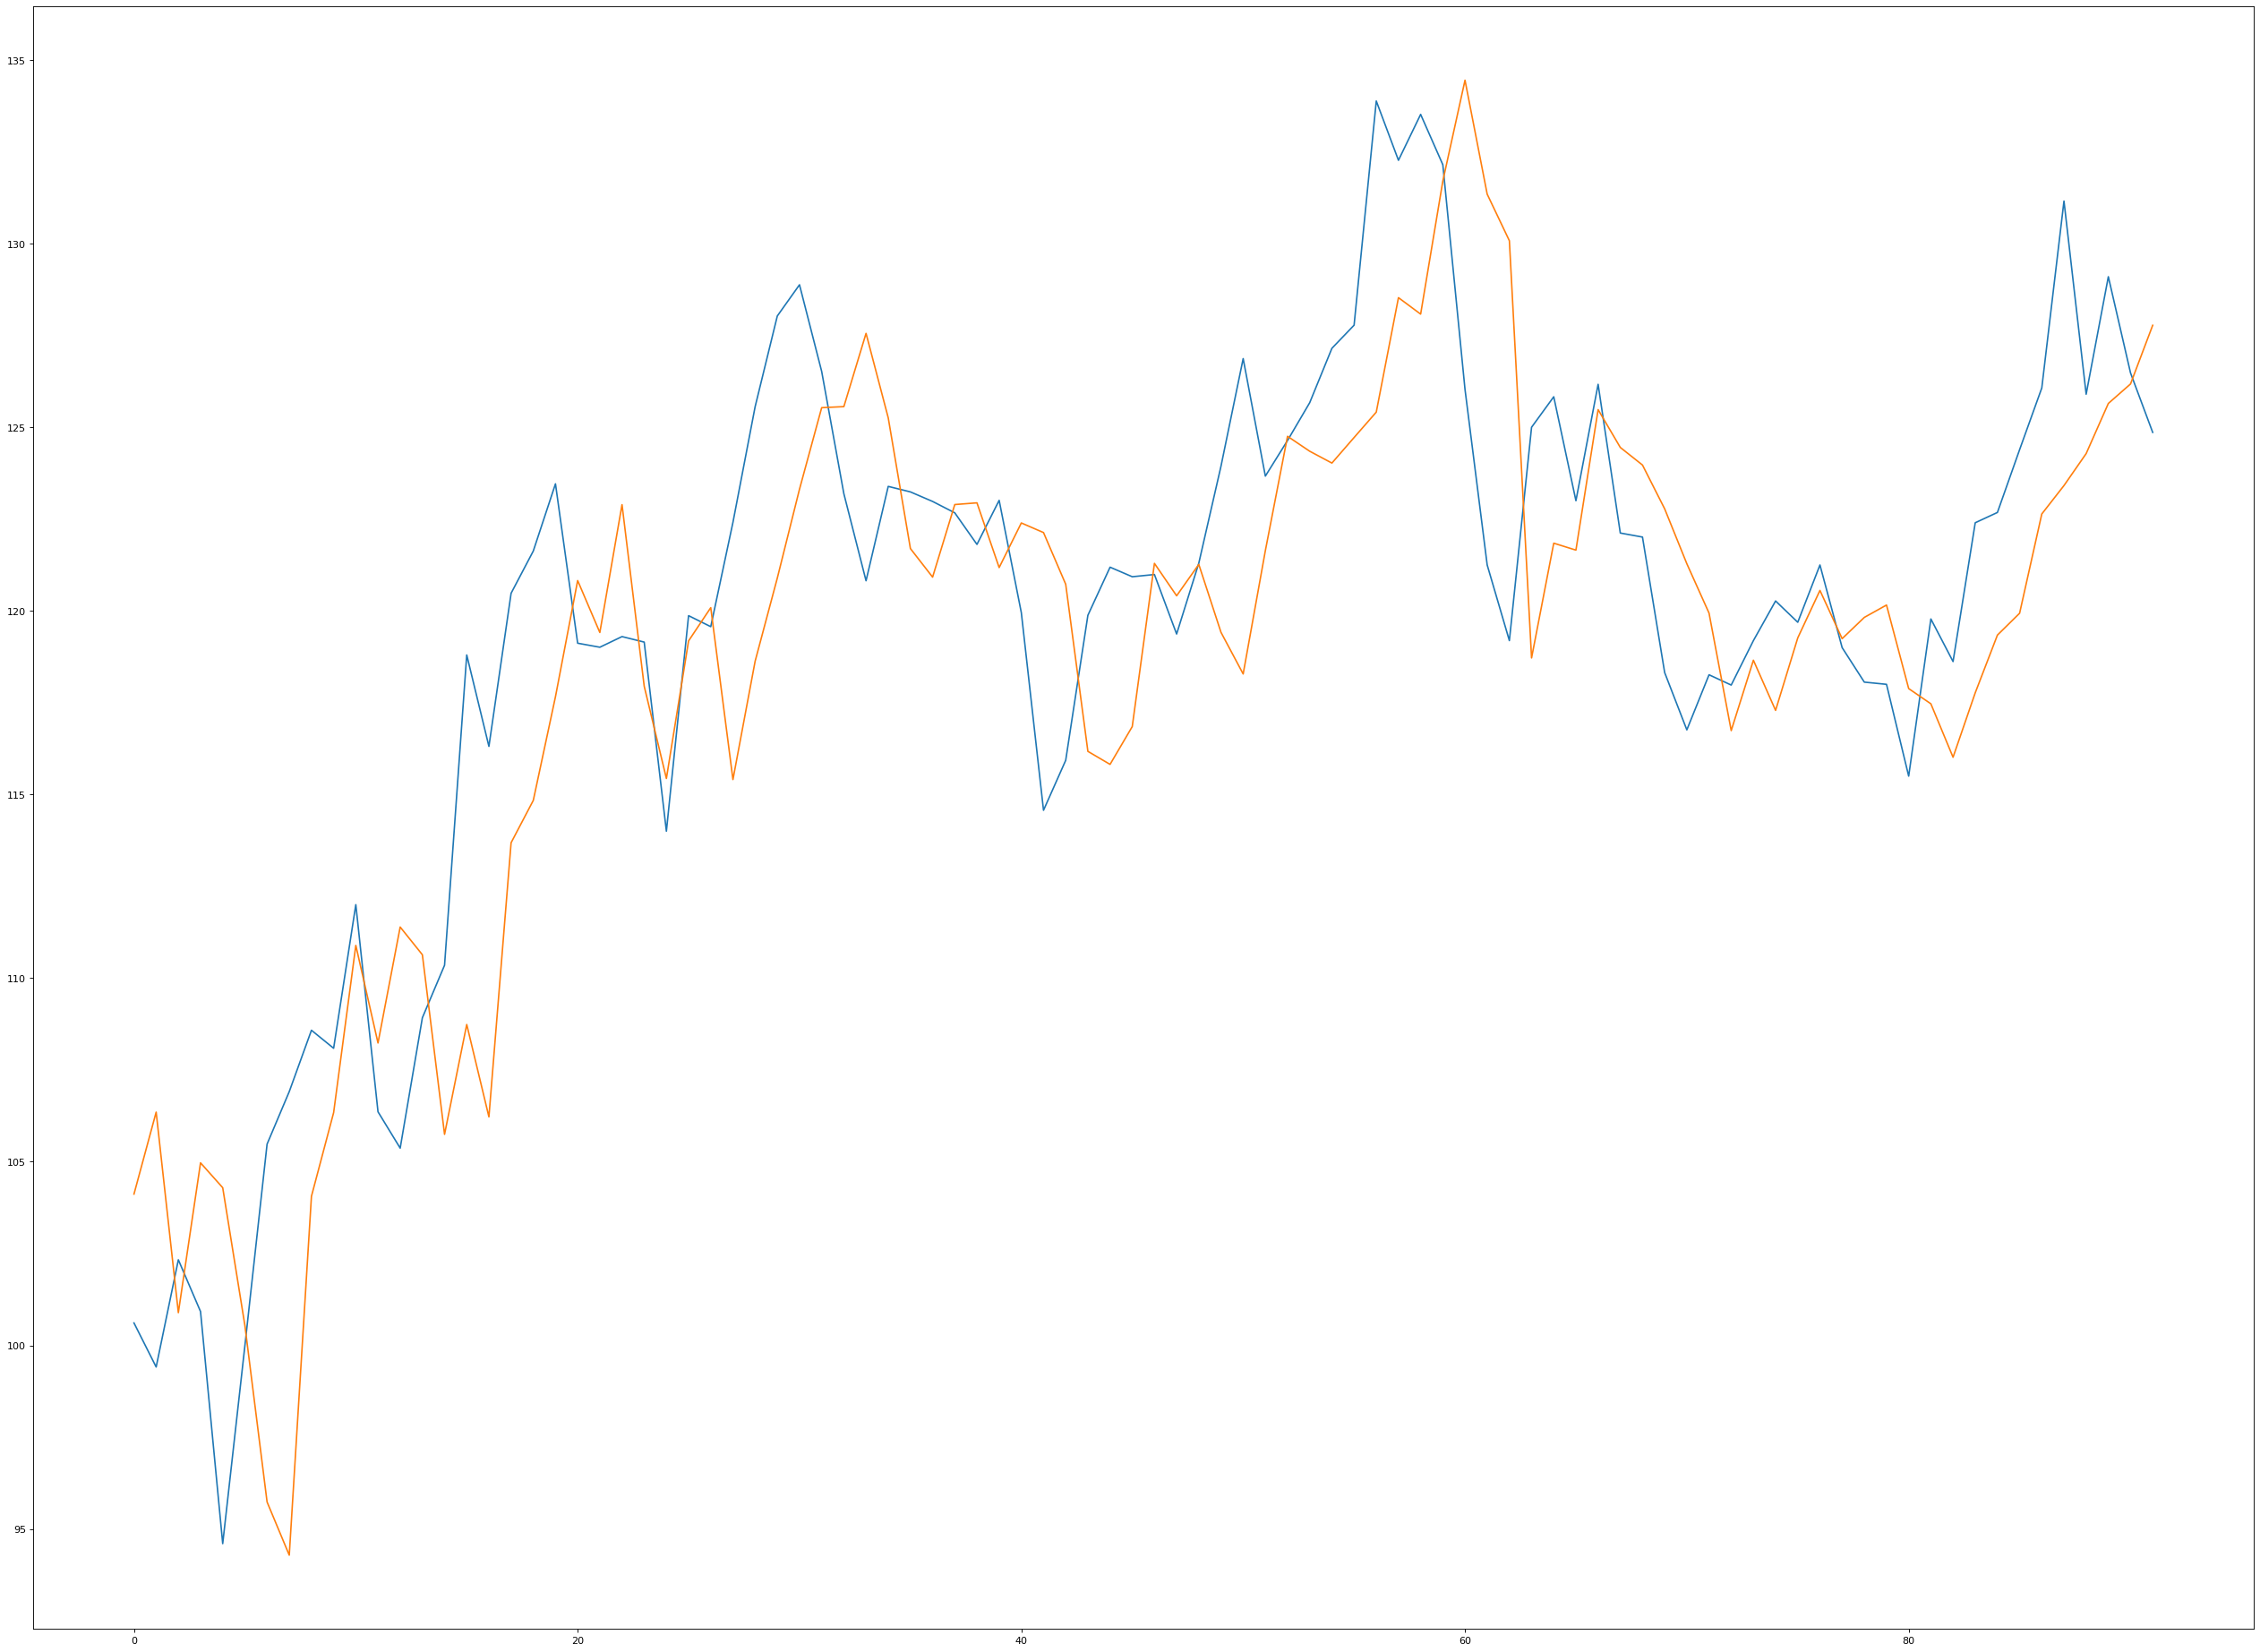

In [33]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(40, 30), dpi=80, facecolor='w', edgecolor='k')

plt.plot(range(92), unscaled_y_test[-92:])
plt.plot(range(92), predicted_y_test[-92:])
plt.show()

##### Last 2 days + prediction of next 2 days

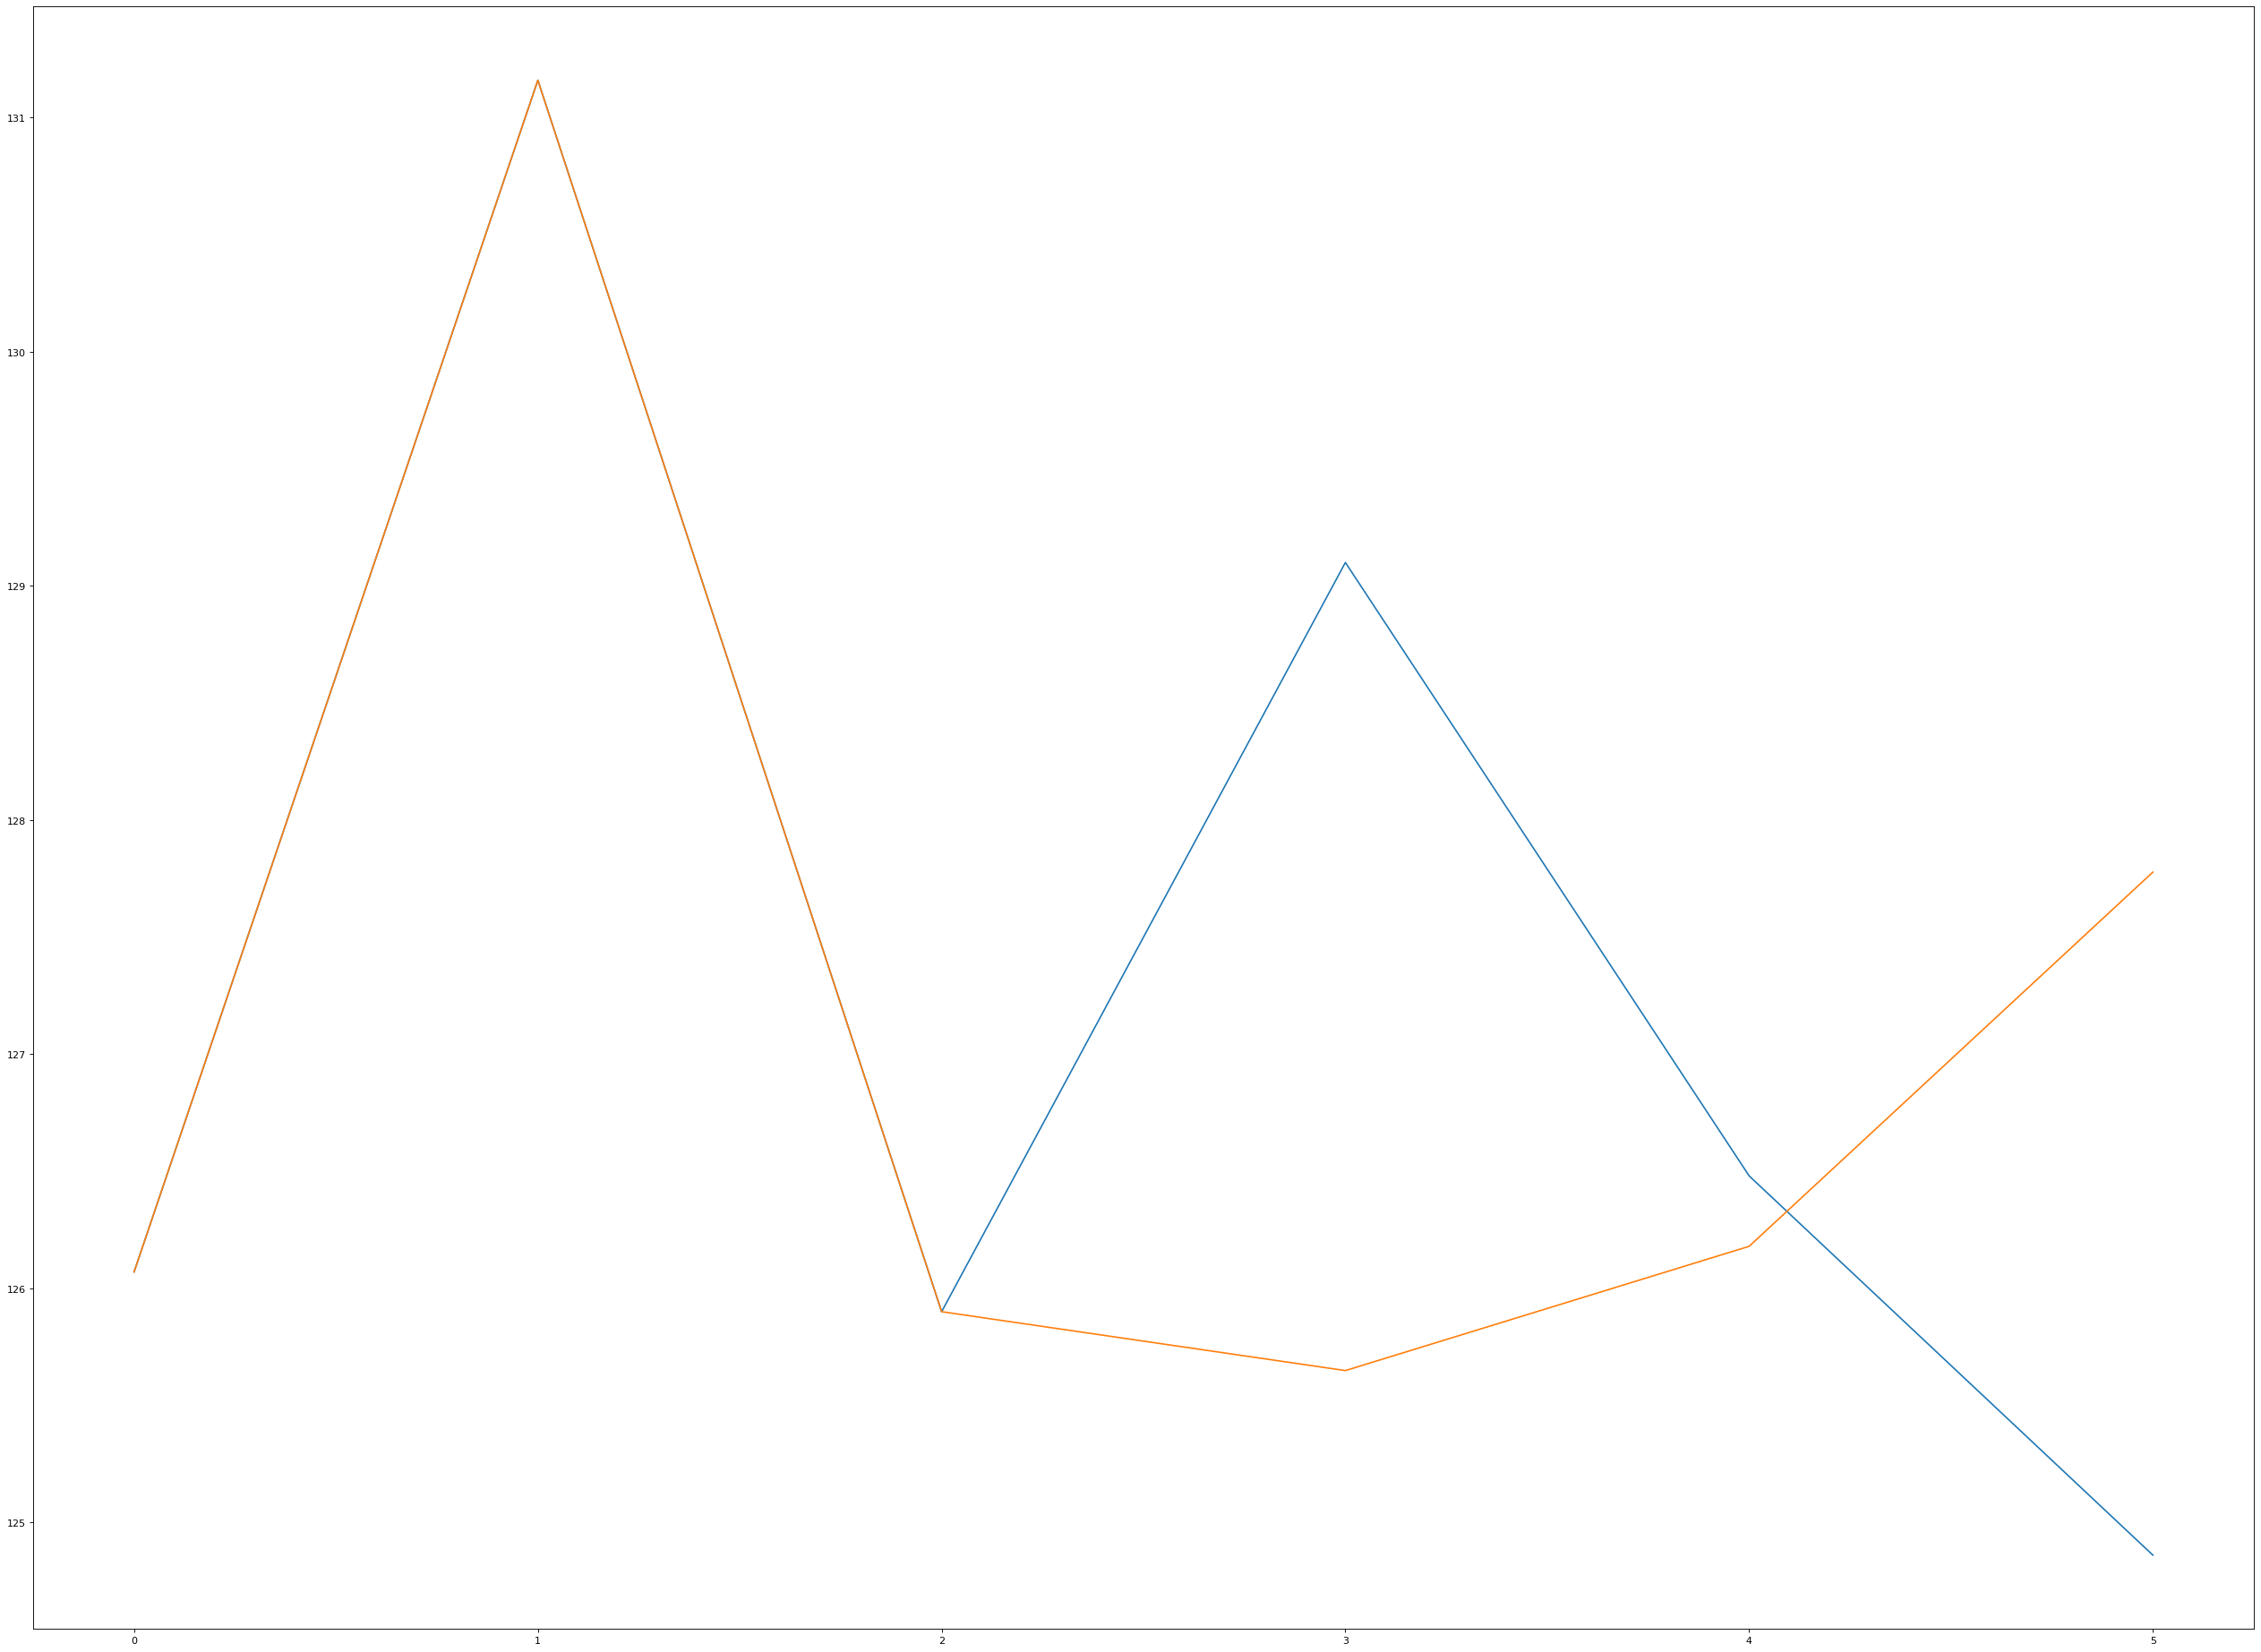

In [34]:
figure(num=None, figsize=(40, 30), dpi=80, facecolor='w', edgecolor='k')

plt.plot(range(6), unscaled_y_test[-6:])
plt.plot(range(6), np.append(unscaled_y_test[-6:-3], predicted_y_test[-3:]))
plt.show()